In [1]:
import jupyter

# Comparação por scaler
| Scaler               | Train (↓ melhor) | Test (↓ melhor) | Comentário                     |
| -------------------- | ---------------- | --------------- | ------------------------------ |
| **PowerTransformer** | **0.0058**       | **0.0354**      | 🔥 Melhor separabilidade geral |
| QuantileTransformer  | 0.0112           | 0.0380          | Bom em geral                   |
| StandardScaler       | 0.0115           | 0.0375          | Similar ao Quantile            |
| RobustScaler         | 0.0119           | 0.0464          | Um pouco pior em teste         |
| **MinMaxScaler**     | 0.0260           | **0.0664**      | 🚫 Fraca generalização         |
| **MaxAbsScaler**     | **0.0444**       | 0.0524          | 🚫 Muito fraco                 |


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from src.utils.system import boot
from src.defaults import TOP2_STOCK_BY_SECTOR, RANDOM_SEEDS
from src.data.feature_pipeline import load_base_dataframe

DEVICE = boot()
OHLCV_DF = load_base_dataframe()

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from hurst import compute_Hc
from pyts.image import RecurrencePlot
import datetime

# PROJECT SETUP ==================================
TICKERS         = TOP2_STOCK_BY_SECTOR
#TICKERS = OHLCV_DF['symbol'].unique()
#TICKERS = TOP2_STOCK_BY_SECTOR 

CHAOS_THRESHOLD = 0.45
WINDOW_SIZE     = 120
ENTROPY_BINS    = 10
N_WEEK_DAYS     = 5
STEP_SIZE       = 20
MAX_LEN         = 64
LOOKBACK_BUFFER = 40
ROLLING_WINDOW  = 5
START_DATE      = "2023-01-01",
END_DATE        = "2025-05-01"#pd.Timestamp.today().replace(day=1)
TRAIN_MONTHS    = 2
TEST_MONTHS     = 1
MIN_WINDOW_DAYS = 20
NUM_EPOCHS      = 1
SEEDS = RANDOM_SEEDS[:5]

""" 
DEVELOPER NOTES:
@todo : onehot encode day_of_week so the Model wont use the data as a sized sequence 
"""
BASIC_FEATURES=[
    "close"	,          # Core price for reward and trend awareness
    "volume",          # Volume for activity level
    "candle_body",     # Price strength (close-open)
    "upper_shadow",    # Wick size = volatility / exhaustion
    "lower_shadow",    # Same as above
    "order_flow",      # Flow = pressure indicator (buy/sell imbalance)
    "price_change",    # Price momentum short term
    "volatility",      # Recent price dispersion
    "momentum",        # Rolling price trend
    "vix_norm",        # Implied market risk normalized
    "market_return_1d",# Market regime alignment
    "day_of_week"      # heard it's important                
]

# That’s 12 columns, enough to:
# * See price movement
# * Detect regime shifts
# * Respond to risk

# Second Round:
# * overnight_price_change → if overnight gaps matter to your strategy
# * trade_count_change → intraday activity shifts
# * sp500_norm → macro regime normalization

DEFAULT_INTERNAL_FEATURES = [
    "position",
    "holding_period",
    "cumulative_reward",
    "pct_time",
    "drawdown",
    "unrealized_pnl",
    "entry_price",
    "time_in_position",
    "prev_action"
]



# Data preparation

In [4]:
# STEP 1 - GET DATA =======================
# POC

EXPERIENCE_NAME="peak_analysis"

results_path = f"data/experiments/{EXPERIENCE_NAME}.csv"

TICKERS = TOP2_STOCK_BY_SECTOR

df = OHLCV_DF[OHLCV_DF['symbol'].isin(TICKERS)].copy()


#df = OHLCV_DF[OHLCV_DF['symbol'] == ticker].copy()

df = df.sort_values("date").reset_index(drop=True)




<Axes: >

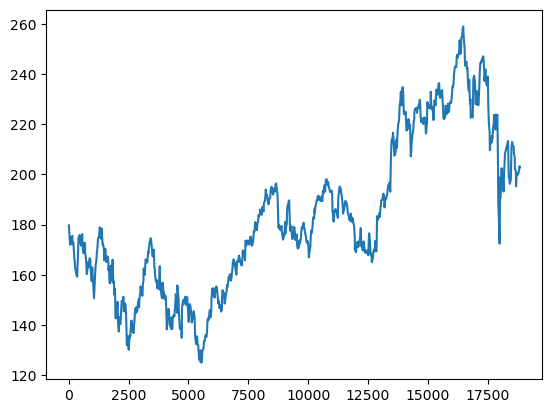

In [5]:
aapl_df = df[df['symbol']=="AAPL"]
aapl_df['close'].plot()

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def detect_peaks_and_troughs(df, prominence=0.01, distance=5):
    prices = df['close'].values

    # Find peaks (maxima)
    peaks, _ = find_peaks(prices, prominence=prominence, distance=distance)
    # Find troughs (minima)
    troughs, _ = find_peaks(-prices, prominence=prominence, distance=distance)

    return peaks, troughs

def plot_trend_reversals(df, peaks, troughs, title="Trend Reversals"):
    plt.figure(figsize=(15, 6))
    plt.plot(df['date'], df['close'], label='Close Price', color='black', alpha=0.7)
    plt.scatter(df['date'].iloc[peaks], df['close'].iloc[peaks], color='red', marker='^', label='Peaks')
    plt.scatter(df['date'].iloc[troughs], df['close'].iloc[troughs], color='green', marker='v', label='Troughs')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


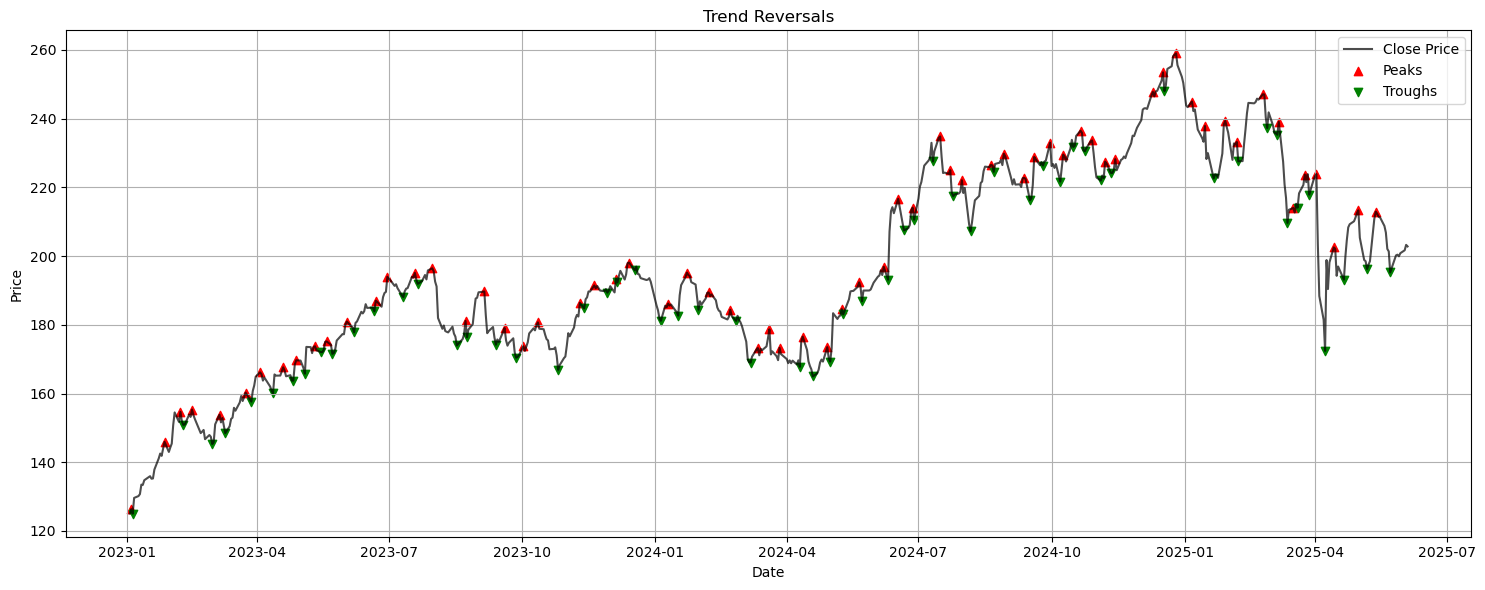

In [7]:
# Filter a long slice of AAPL (e.g., 2023)
aapl_df = OHLCV_DF[(OHLCV_DF["symbol"] == "AAPL") & 
                   (OHLCV_DF["date"] >= "2023-01-01")].copy()

# Detect reversals
peaks, troughs = detect_peaks_and_troughs(aapl_df, prominence=1, distance=5)

# Plot them
plot_trend_reversals(aapl_df, peaks, troughs)

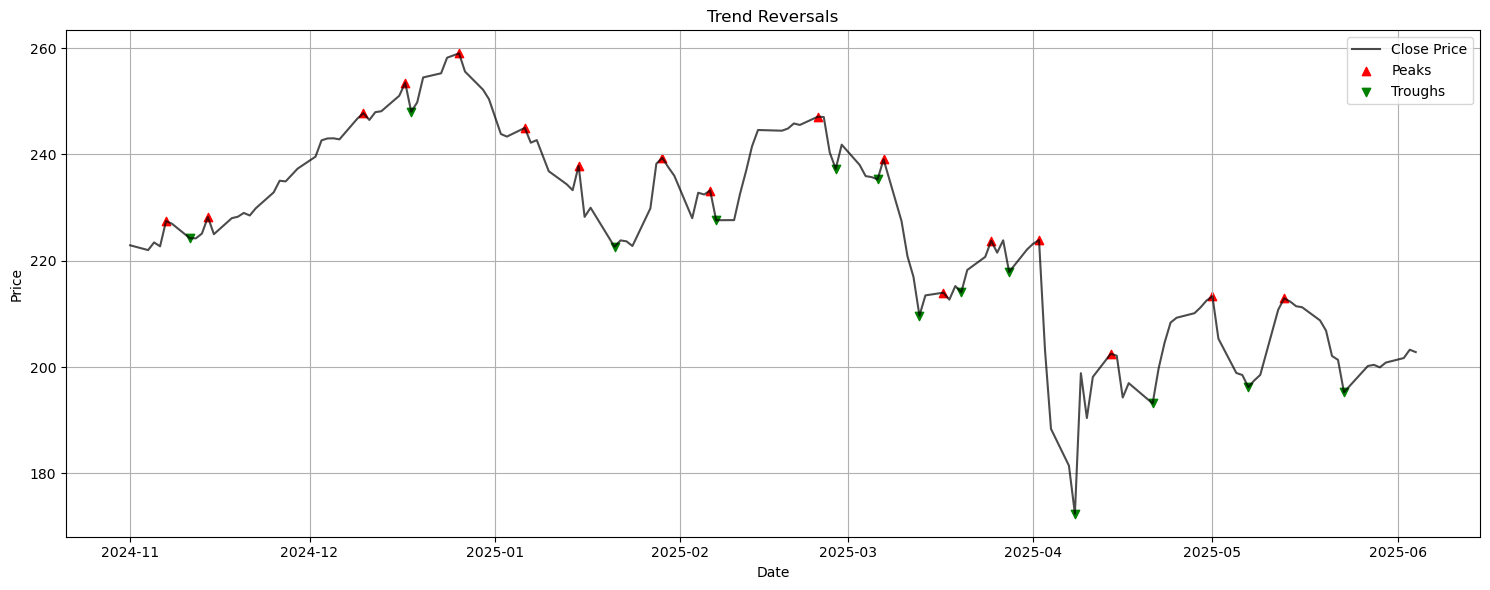

In [11]:
recent_aapl_df = aapl_df[aapl_df['date']>='2024-11-01']
peaks, troughs = detect_peaks_and_troughs(recent_aapl_df, prominence=1, distance=5)

# Plot them
plot_trend_reversals(recent_aapl_df, peaks, troughs)

In [46]:
len(aapl_df)

607

In [47]:
signals_through_time = []

for i in range(300):  # simulate 300 steps
    sample = aapl_df.iloc[:300 + i].copy()

    # Detect trend points causally
    peaks, troughs = detect_peaks_and_troughs(sample, prominence=1, distance=5)

    # Only label indices that were visible at the time (exclude future-confirmed peaks)
    confirmed_peaks = [p for p in peaks if p < len(sample)]
    confirmed_troughs = [t for t in troughs if t < len(sample)]

    signals_through_time.append({
        "step": 300 + i,
        "peaks": np.array(confirmed_peaks),
        "troughs": np.array(confirmed_troughs),
    })

In [48]:
len(signals_through_time)

300

In [49]:
troughs

array([  2,  26,  39,  46,  58,  68,  78,  84,  91,  97, 107, 116, 129,
       137, 156, 161, 174, 184, 205, 217, 228, 233, 241, 253, 260, 270,
       287, 295, 318, 325, 333, 340, 349, 360, 368, 373, 381, 391, 399,
       411, 427, 434, 442, 449, 455, 462, 467, 493, 513, 526, 539, 544,
       549, 554, 560, 567, 575, 587], dtype=int64)

In [27]:
time_troughs

[array([ 6, 32, 52, 65, 78, 83], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93, 99], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93, 99], dtype=int64),
 array([ 6, 32, 52, 65, 78, 83, 88, 93, 99], dtype=int64),
 ar

# Problem statement

Reversal points are consistently detected ~2 days late, just enough to miss optimal entries or exits.

**What This Confirms**
* find_peaks is reactive, not predictive.
  * It waits for confirmation (decline after a rise, rise after a drop).
  *  So it’s accurate but late — which is bad in fast-moving markets.

* The delay is systematic:
  * The reversal happens (e.g., price hits top), but detection needs to "see" the drop.
  * That delay is visible in the  step logs and visual trail.

### What now:
Let’s learn from the delay and try to anticipate reversals before they fully form.

# Phase 2: Meta-Feature Analysis Around Reversals

In [50]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

In [51]:
def extract_meta_features(df, reversal_indices, window=5):
    """
    For each row t, extract meta-features using [t-window, t]
    Label as 1 if t in reversal_indices (peak or trough), else 0
    """
    features = []

    for i in range(window, len(df)):
        window_df = df.iloc[i - window:i]

        # Core series
        closes = window_df["close"].values
        returns = np.diff(closes)

        # Features (can expand later)
        feature_dict = {
            "date": df.iloc[i]["date"],
            "mean_return": returns.mean(),
            "std_return": returns.std(),
            "skew_return": skew(returns),
            "kurt_return": kurtosis(returns),
            "rolling_max": closes.max(),
            "rolling_min": closes.min(),
            "drawdown": closes.max() - closes[-1],
            "recovery": closes[-1] - closes.min(),
        }

        # Label if current index is in reversal list
        feature_dict["is_peak"] = int(i in reversal_indices["peaks"])
        feature_dict["is_trough"] = int(i in reversal_indices["troughs"])

        features.append(feature_dict)

    return pd.DataFrame(features)


In [52]:
latest_signals = signals_through_time[-1]
meta_df = extract_meta_features(aapl_df.reset_index(drop=True), latest_signals, window=5)
meta_df

,date,mean_return,std_return,skew_return,kurt_return,rolling_max,rolling_min,drawdown,recovery,is_peak,is_trough
0,2023-01-10,1.2700,2.147615,0.473009,-1.006047,130.15,125.02,0.00,5.13,0,0
1,2023-01-11,1.0925,2.167872,0.697993,-0.888639,130.73,125.02,0.00,5.71,0,0
2,2023-01-12,2.1175,1.692607,0.408788,-1.474315,133.49,125.02,0.00,8.47,0,0
3,2023-01-13,0.9475,1.078225,0.946771,-0.788585,133.49,129.62,0.08,3.79,0,0
4,2023-01-17,1.1525,1.057104,0.444792,-1.179395,134.76,130.15,0.00,4.61,0,0
...,...,...,...,...,...,...,...,...,...,...,...
597,2025-05-29,-0.4175,3.916997,-0.118696,-1.025316,202.09,195.27,1.67,5.15,0,0
598,2025-05-30,-0.3525,3.913428,-0.168728,-1.008557,201.36,195.27,1.41,4.68,0,0
599,2025-06-02,1.3950,2.103242,0.974799,-0.801819,200.85,195.27,0.00,5.58,0,0
600,2025-06-03,0.3725,0.557332,-0.500598,-1.357408,201.70,199.95,0.00,1.75,0,0


In [53]:
latest_signals

{'step': 599,
 'peaks': array([  1,  17,  24,  30,  42,  56,  62,  73,  80,  89,  95, 104, 117,
        123, 135, 143, 160, 168, 178, 187, 195, 216, 222, 232, 239, 256,
        264, 275, 285, 298, 304, 309, 320, 331, 339, 347, 359, 365, 372,
        384, 389, 395, 409, 416, 425, 430, 437, 444, 452, 458, 465, 470,
        487, 492, 498, 504, 510, 519, 525, 536, 545, 551, 557, 563, 571,
        583, 591], dtype=int64),
 'troughs': array([  2,  26,  39,  46,  58,  68,  78,  84,  91,  97, 107, 116, 129,
        137, 156, 161, 174, 184, 205, 217, 228, 233, 241, 253, 260, 270,
        287, 295, 318, 325, 333, 340, 349, 360, 368, 373, 381, 391, 399,
        411, 427, 434, 442, 449, 455, 462, 467, 493, 513, 526, 539, 544,
        549, 554, 560, 567, 575, 587], dtype=int64)}

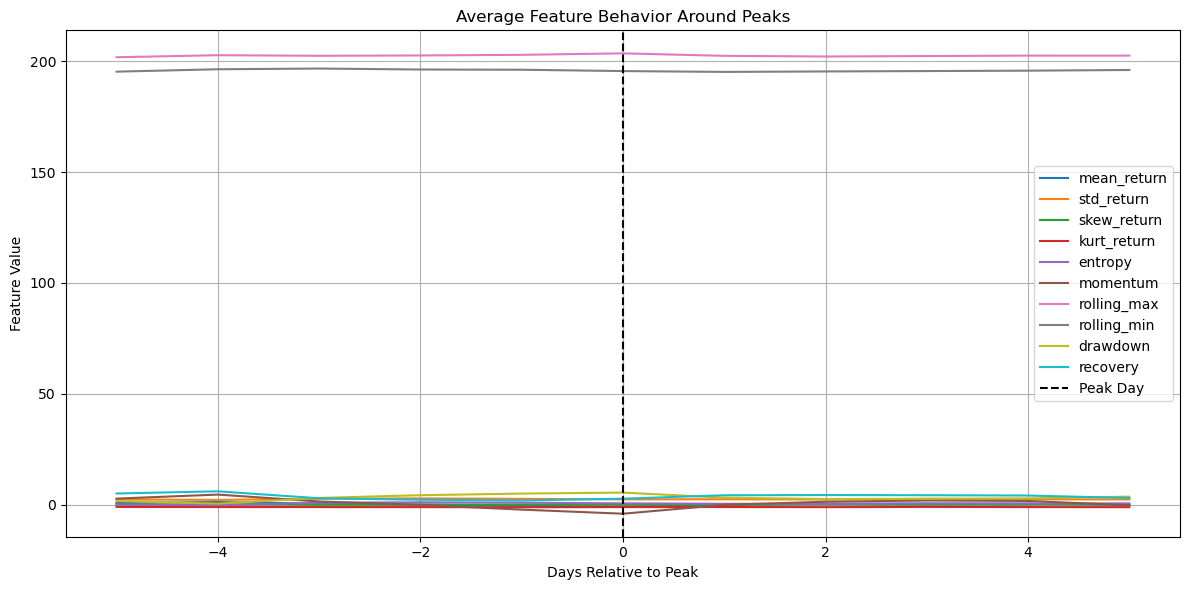

In [55]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import hilbert
from sklearn.preprocessing import StandardScaler

def compute_entropy(signal, bins=10):
    hist, _ = np.histogram(signal, bins=bins, density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log(hist))

def compute_momentum(signal):
    return signal[-1] - signal[0]

def extract_meta_features_with_entropy_momentum(df, reversal_indices, window=5):
    features = []

    for i in range(window, len(df)):
        window_df = df.iloc[i - window:i]
        closes = window_df["close"].values
        returns = np.diff(closes)

        entropy_val = compute_entropy(returns, bins=10)
        momentum_val = compute_momentum(closes)

        feature_dict = {
            "date": df.iloc[i]["date"],
            "mean_return": returns.mean(),
            "std_return": returns.std(),
            "skew_return": skew(returns),
            "kurt_return": kurtosis(returns),
            "entropy": entropy_val,
            "momentum": momentum_val,
            "rolling_max": closes.max(),
            "rolling_min": closes.min(),
            "drawdown": closes.max() - closes[-1],
            "recovery": closes[-1] - closes.min(),
            "is_peak": int(i in reversal_indices["peaks"]),
            "is_trough": int(i in reversal_indices["troughs"]),
        }

        features.append(feature_dict)

    return pd.DataFrame(features)

# Placeholder for recent_aapl_df and latest_signals
# Assuming those are provided externally and are already aligned
# Let's simulate some dummy data for plotting purpose
"""
dates = pd.date_range(start="2024-11-01", periods=120, freq="D")
np.random.seed(42)
close_prices = np.cumsum(np.random.randn(120)) + 200

# Simulated peaks and troughs
simulated_peaks = np.array([20, 40, 60, 85, 100])
simulated_troughs = np.array([10, 30, 55, 90, 110])
recent_aapl_df = pd.DataFrame({"date": dates, "close": close_prices})
"""
simulated_peaks = np.array(latest_signals['peaks'])
simulated_troughs = np.array(latest_signals['troughs'])
_latest_signals = {"peaks": simulated_peaks, "troughs": simulated_troughs}

# Extract meta features
meta_df = extract_meta_features_with_entropy_momentum(aapl_df.reset_index(drop=True), _latest_signals, window=5)

# Compute rolling mean of features around peaks
window_size = 5
peak_windows = []

for peak_idx in simulated_peaks:
    if peak_idx >= window_size and peak_idx + window_size < len(meta_df):
        window = meta_df.iloc[peak_idx - window_size : peak_idx + window_size + 1]
        peak_windows.append(window.drop(columns=["date", "is_peak", "is_trough"]).values)

# Average behavior
avg_peak_features = np.mean(peak_windows, axis=0)
feature_names = meta_df.drop(columns=["date", "is_peak", "is_trough"]).columns

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare dataframe for plotting
plot_df = pd.DataFrame(avg_peak_features, columns=feature_names)
plot_df["day_offset"] = range(-window_size, window_size + 1)
plot_df = plot_df.set_index("day_offset")

# Plot
plt.figure(figsize=(12, 6))
for col in plot_df.columns:
    plt.plot(plot_df.index, plot_df[col], label=col)

plt.axvline(0, color='black', linestyle='--', label="Peak Day")
plt.title("Average Feature Behavior Around Peaks")
plt.xlabel("Days Relative to Peak")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
plot_df

,mean_return,std_return,skew_return,kurt_return,entropy,momentum,rolling_max,rolling_min,drawdown,recovery
day_offset,,,,,,,,,,
-5,0.665133,2.279958,-0.047658,-1.097532,-0.033676,2.660530,201.823485,195.317121,1.537045,4.969318
-4,1.118977,2.085341,0.075652,-1.147919,-0.337438,4.475909,202.736818,196.396061,0.386667,5.954091
-3,0.342481,2.569295,-0.097899,-1.159190,0.792598,1.369924,202.477424,196.714242,2.954773,2.808409
-2,-0.048977,2.749820,-0.033993,-1.183771,0.998588,-0.195909,202.623485,196.284545,4.196818,2.142121
-1,-0.577292,2.555299,-0.067558,-1.242063,0.801218,-2.309167,202.906364,196.179848,4.929091,1.797424
0,-1.038068,2.307794,-0.070492,-1.161564,0.515904,-4.152273,203.573636,195.577121,5.375758,2.620758
1,-0.038845,2.368380,-0.086632,-1.137124,0.321013,-0.155379,202.452500,195.201364,3.085227,4.165909
2,0.312348,2.238912,-0.020338,-1.189711,0.266438,1.249394,202.144697,195.406515,2.468636,4.269545
3,0.450644,2.552489,-0.116323,-1.097967,0.401433,1.802576,202.353333,195.585909,2.573485,4.193939


| Feature                       | Pre-Peak Behavior                              | Peak Day            | Post-Peak Signal  |
| ----------------------------- | ---------------------------------------------- | ------------------- | ----------------- |
| **Momentum**                  | Drops sharply from -3 days, collapses by day 0 | Minimum at day 0    | Rebounds slightly |
| **Entropy**                   | Rises gradually, peaks exactly at reversal     | Highest at day 0    | Declines after    |
| **Mean Return**               | Negative drift begins at -2                    | Strongest drop at 0 | Recovers slightly |
| **Volatility** (`std_return`) | Increases sharply into the peak                | Sustained high      | Slightly elevated |
| **Drawdown**                  | Increases consistently toward peak             | Highest at 0        | Falls back post   |
| **Recovery**                  | Shrinks into peak                              | Low at day 0        | Increases after   |
### Interpretation
* **Momentum** + **entropy** are early warning indicators.
* **Drawdown** and **volatility** give confirmation after the fact.
* **Mean return shift** + **entropy spike** is particularly predictive.



C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

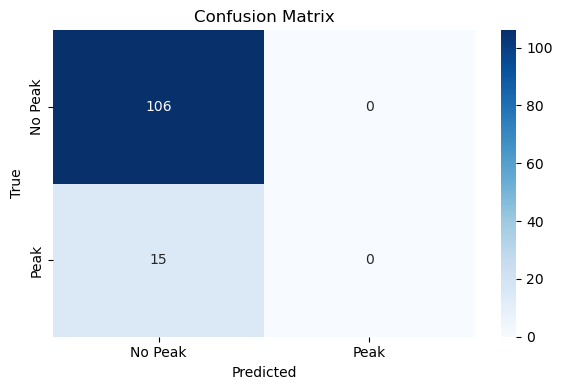

(kurt_return    0.147616
 recovery       0.140259
 drawdown       0.098866
 skew_return    0.098173
 rolling_max    0.094227
 mean_return    0.094061
 momentum       0.088223
 entropy        0.083653
 std_return     0.078152
 rolling_min    0.076772
 dtype: float64,
 {'0': {'precision': 0.8760330578512396,
   'recall': 1.0,
   'f1-score': 0.933920704845815,
   'support': 106.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15.0},
  'accuracy': 0.8760330578512396,
  'macro avg': {'precision': 0.4380165289256198,
   'recall': 0.5,
   'f1-score': 0.4669603524229075,
   'support': 121.0},
  'weighted avg': {'precision': 0.7674339184481934,
   'recall': 0.8760330578512396,
   'f1-score': 0.8181454108566644,
   'support': 121.0}})

In [58]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the dataset
X = meta_df.drop(columns=["date", "is_peak", "is_trough"])
y = meta_df["is_peak"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Peak", "Peak"], yticklabels=["No Peak", "Peak"])
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

importances.head(10), report

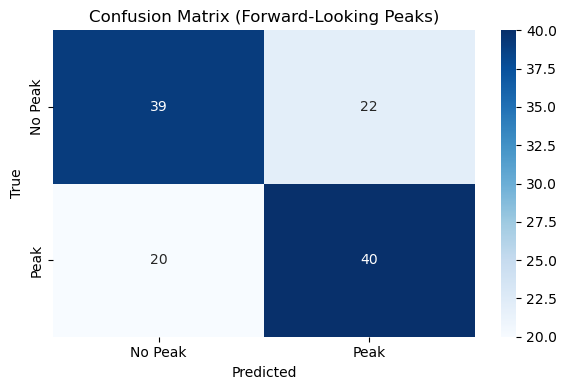

(drawdown       0.132130
 std_return     0.128634
 entropy        0.122994
 recovery       0.102864
 mean_return    0.099847
 momentum       0.094920
 kurt_return    0.082637
 skew_return    0.082538
 rolling_min    0.076928
 rolling_max    0.076509
 dtype: float64,
 {'0': {'precision': 0.6610169491525424,
   'recall': 0.639344262295082,
   'f1-score': 0.65,
   'support': 61.0},
  '1': {'precision': 0.6451612903225806,
   'recall': 0.6666666666666666,
   'f1-score': 0.6557377049180327,
   'support': 60.0},
  'accuracy': 0.6528925619834711,
  'macro avg': {'precision': 0.6530891197375615,
   'recall': 0.6530054644808743,
   'f1-score': 0.6528688524590164,
   'support': 121.0},
  'weighted avg': {'precision': 0.653154638988925,
   'recall': 0.6528925619834711,
   'f1-score': 0.6528451429345618,
   'support': 121.0}},
 imminent_peak
 0    336
 1    266
 Name: count, dtype: int64)

In [59]:
# Re-label dataset with forward-looking logic: mark days where a peak is within the next 3 days
def label_imminent_peaks(df, peak_indices, lookahead=3):
    label = np.zeros(len(df), dtype=int)
    for p in peak_indices:
        for offset in range(lookahead + 1):  # include the peak day itself
            if p - offset >= 0:
                label[p - offset] = 1
    return label

# Apply forward-looking labeling
meta_df["imminent_peak"] = label_imminent_peaks(meta_df, latest_signals["peaks"], lookahead=3)

# Check class balance
class_counts = meta_df["imminent_peak"].value_counts()

# Prepare data
X = meta_df.drop(columns=["date", "is_peak", "is_trough", "imminent_peak"])
y = meta_df["imminent_peak"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Use class-weighted RandomForest
clf_balanced = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf_balanced.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf_balanced.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
importances = pd.Series(clf_balanced.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Peak", "Peak"], yticklabels=["No Peak", "Peak"])
plt.title("Confusion Matrix (Forward-Looking Peaks)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

importances.head(10), report, class_counts


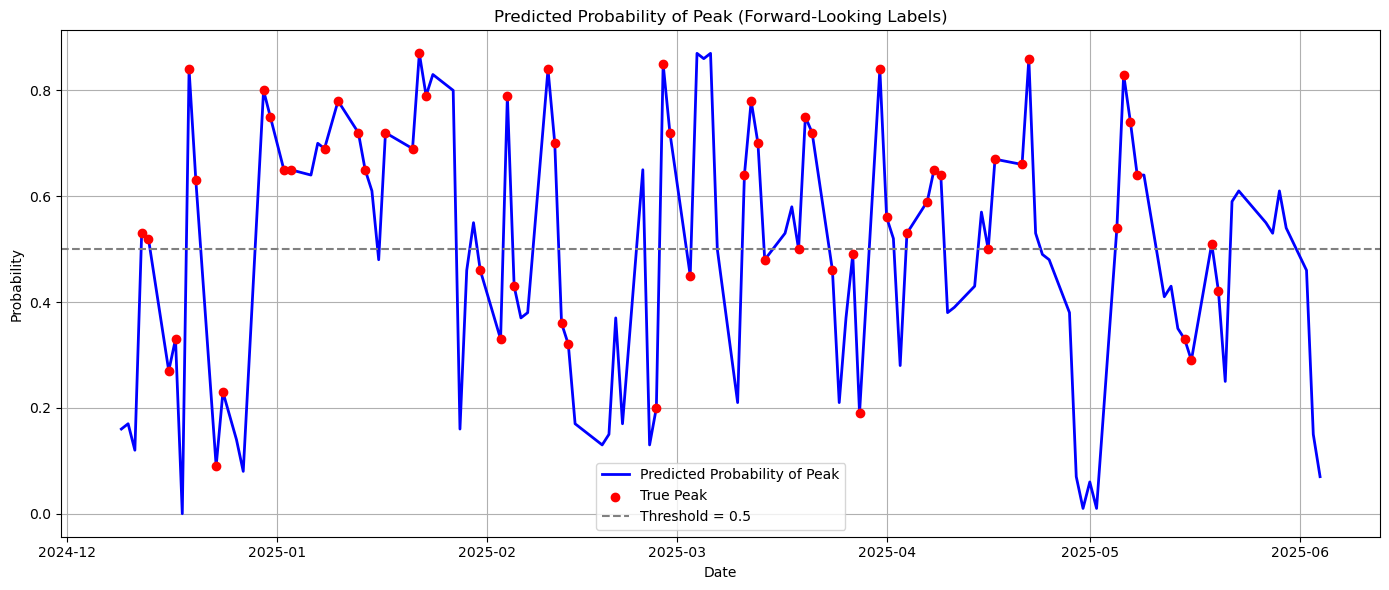

In [60]:
# Get predicted probabilities for class 1 (peak)
y_proba = clf_balanced.predict_proba(X_test)[:, 1]

# Extract dates for visualization
dates_test = meta_df.iloc[y_test.index]["date"].reset_index(drop=True)
true_labels = y_test.reset_index(drop=True)

# Build DataFrame for plotting
proba_df = pd.DataFrame({
    "date": dates_test,
    "prob_peak": y_proba,
    "true_label": true_labels
})

# Plot
plt.figure(figsize=(14, 6))
plt.plot(proba_df["date"], proba_df["prob_peak"], label="Predicted Probability of Peak", color="blue", linewidth=2)
plt.scatter(proba_df[proba_df["true_label"] == 1]["date"], 
            proba_df[proba_df["true_label"] == 1]["prob_peak"], 
            color="red", label="True Peak", zorder=5)
plt.axhline(0.5, color='gray', linestyle='--', label="Threshold = 0.5")
plt.title("Predicted Probability of Peak (Forward-Looking Labels)")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


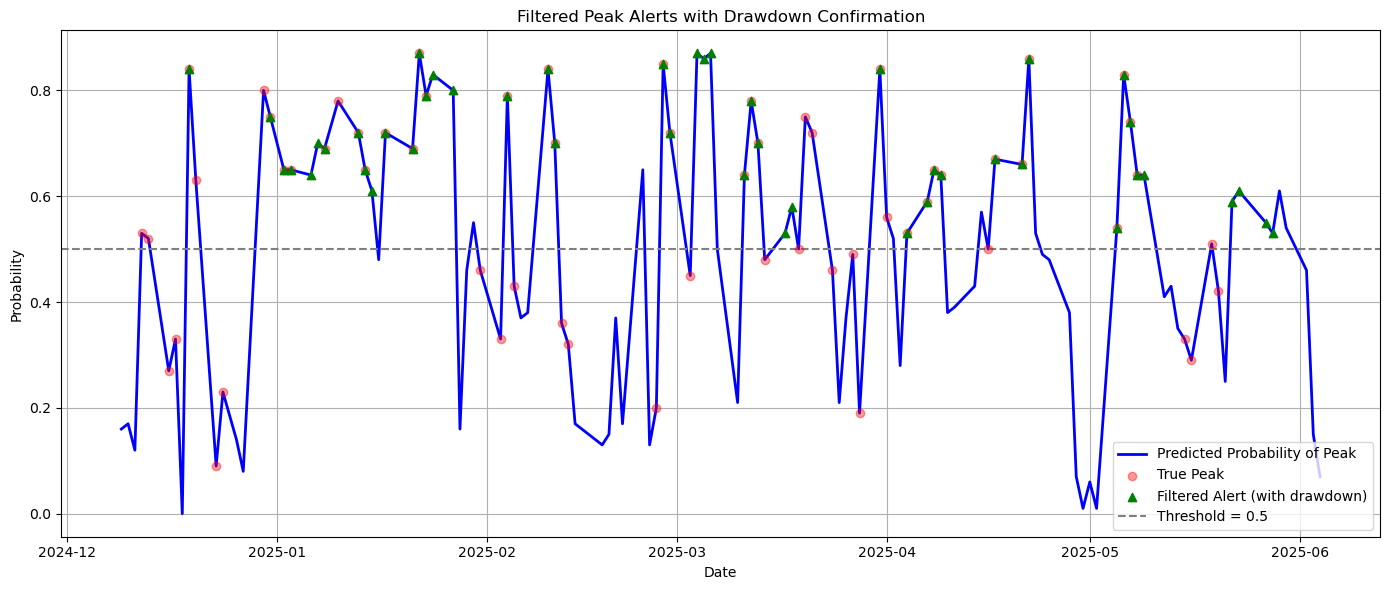

In [64]:
# Add drawdown values back into the test set
drawdown_test = meta_df.iloc[y_test.index]["drawdown"].reset_index(drop=True)

# Combine everything into a DataFrame
proba_df["drawdown"] = drawdown_test

# Apply filtering rule: only signal peak if prob > 0.5 and drawdown > threshold
THRESHOLD_PROB = 0.5
THRESHOLD_DRAWDOWN = 5.0  # can be adjusted or made dynamic

proba_df["alert"] = (proba_df["prob_peak"] > THRESHOLD_PROB) & (proba_df["drawdown"] > THRESHOLD_DRAWDOWN)

# Plot refined signals
plt.figure(figsize=(14, 6))
plt.plot(proba_df["date"], proba_df["prob_peak"], label="Predicted Probability of Peak", color="blue", linewidth=2)
plt.scatter(proba_df[proba_df["true_label"] == 1]["date"],
            proba_df[proba_df["true_label"] == 1]["prob_peak"],
            color="red", label="True Peak", zorder=5, alpha=0.4)

plt.scatter(proba_df[proba_df["alert"] == True]["date"],
            proba_df[proba_df["alert"] == True]["prob_peak"],
            color="green", label="Filtered Alert (with drawdown)", marker="^", zorder=6,alpha=1)

plt.axhline(THRESHOLD_PROB, color='gray', linestyle='--', label=f"Threshold = {THRESHOLD_PROB}")
plt.title("Filtered Peak Alerts with Drawdown Confirmation")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


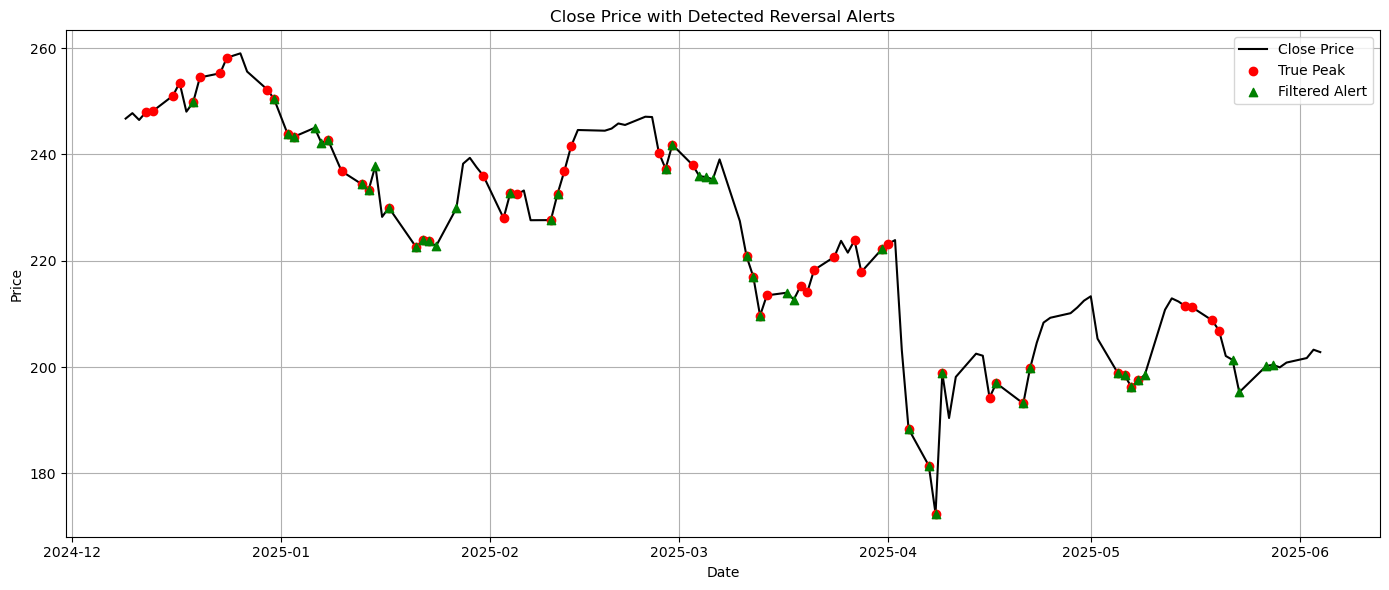

In [66]:

# Merge signal DataFrame with price for visualization
price_test = meta_df.iloc[y_test.index][["date"]].reset_index(drop=True)
price_test["close"] = recent_aapl_df.set_index("date").reindex(price_test["date"]).reset_index(drop=True)["close"]
price_test["alert"] = proba_df["alert"].values
price_test["true_peak"] = proba_df["true_label"].values

# Plot price with alerts and true peaks
plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# Mark true peaks
plt.scatter(price_test[price_test["true_peak"] == 1]["date"],
            price_test[price_test["true_peak"] == 1]["close"],
            color="red", label="True Peak", zorder=5)

# Mark filtered alerts
plt.scatter(price_test[price_test["alert"] == True]["date"],
            price_test[price_test["alert"] == True]["close"],
            color="green", marker="^", label="Filtered Alert", zorder=6)

plt.title("Close Price with Detected Reversal Alerts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Too noisy, lets add cooldown

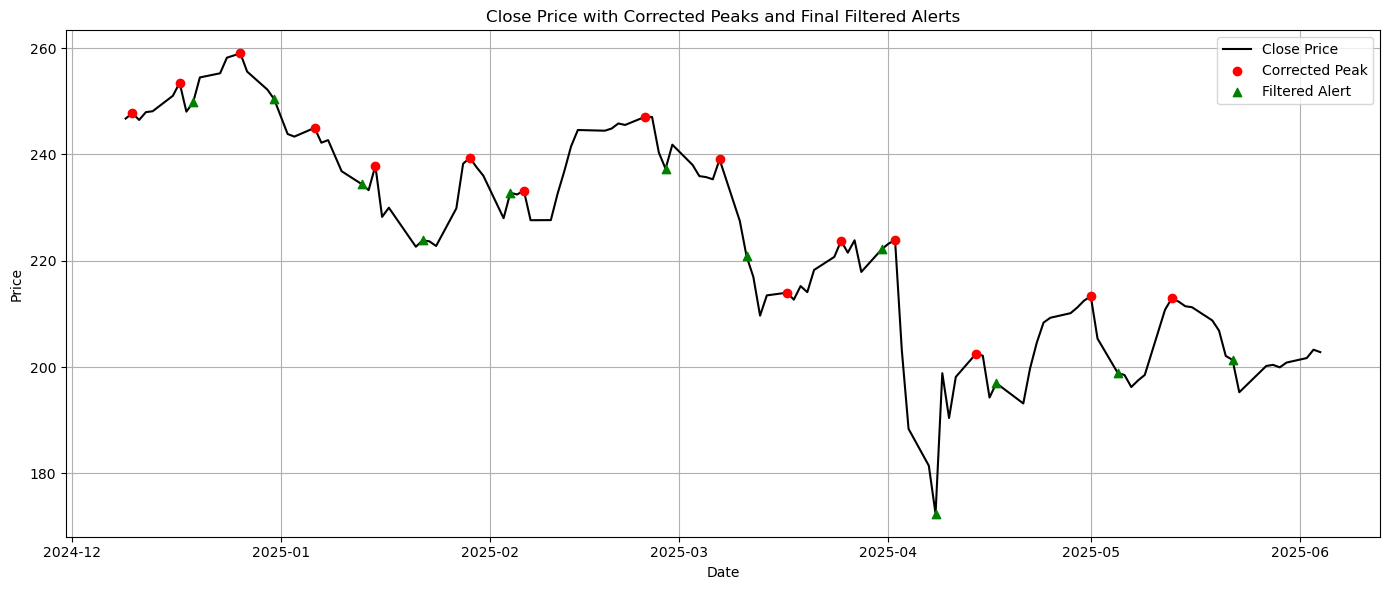

In [68]:
# Re-label true peaks using pure local maxima from price directly
from scipy.signal import find_peaks

# Use full recent AAPL slice (not just meta_df)
prices = recent_aapl_df["close"].values
dates = recent_aapl_df["date"].values

# Detect peaks: local maxima in price
true_peaks_indices, _ = find_peaks(prices, distance=5, prominence=1)
true_peaks_dates = recent_aapl_df.iloc[true_peaks_indices]["date"]

# Re-visualize alerts (filtered with cooldown) against new ground truth peaks
price_test["corrected_true_peak"] = price_test["date"].isin(true_peaks_dates)

# Plot clean comparison
plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# Corrected visual peaks
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Filtered alert (one per cluster)
plt.scatter(price_test[price_test["filtered_alert"] == True]["date"],
            price_test[price_test["filtered_alert"] == True]["close"],
            color="green", marker="^", label="Filtered Alert", zorder=6)

plt.title("Close Price with Corrected Peaks and Final Filtered Alerts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Classification fails , so lets go for rule based
| Feature         | Signal Behavior            |
| --------------- | -------------------------- |
| **Entropy**     | Spikes just before peaks   |
| **Momentum**    | Drops sharply before peaks |
| **Mean Return** | Turns negative             |
| **Drawdown**    | Starts increasing rapidly  |
| **Std. Return** | Starts to expand           |


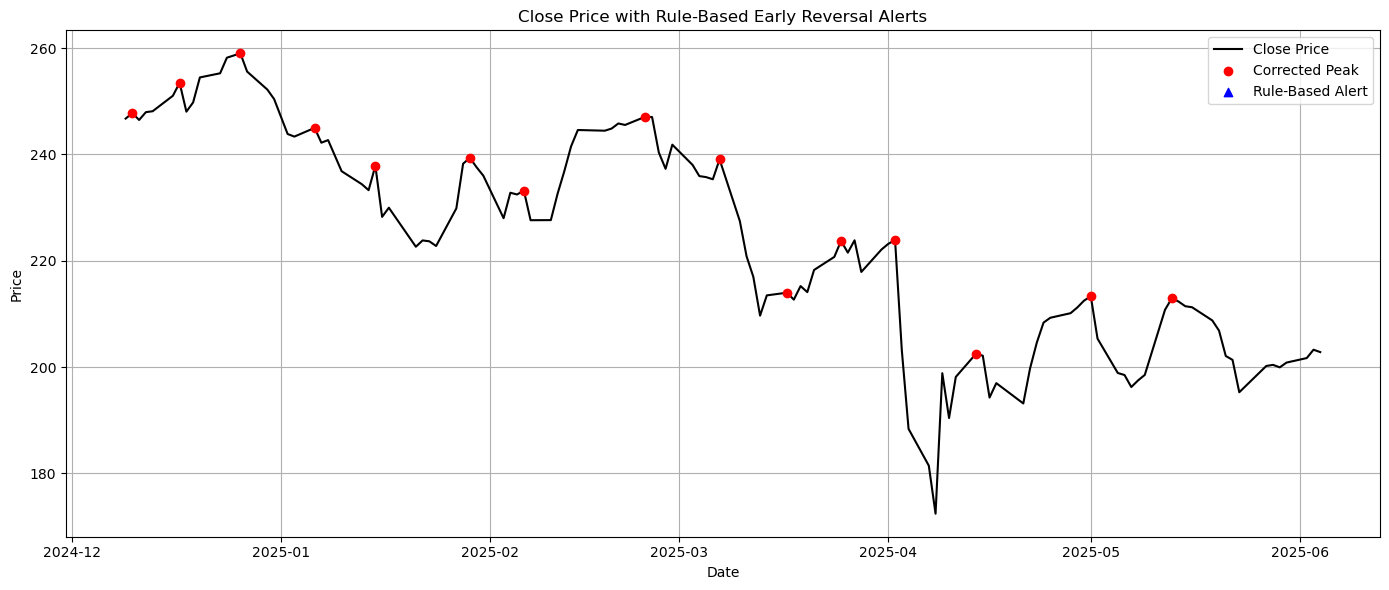

In [69]:
# Compute z-scores for selected predictive features
from scipy.stats import zscore

# Extract relevant columns
feature_columns = ["entropy", "momentum", "mean_return", "drawdown"]
features_z = meta_df[feature_columns].apply(zscore)

# Define thresholds based on z-score logic
# Alert when:
# - entropy is high
# - momentum is low
# - mean_return is negative (z < 0)
# - drawdown is high
alert_signal = (
    (features_z["entropy"] > 0.5) &
    (features_z["momentum"] < -0.5) &
    (features_z["mean_return"] < 0) &
    (features_z["drawdown"] > 0.5)
)

# Add to price_test to visualize
price_test["rule_based_alert"] = alert_signal.iloc[y_test.index].reset_index(drop=True)
price_test["corrected_true_peak"] = price_test["date"].isin(true_peaks_dates)

# Plot rule-based alerts vs peaks
plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# True peaks
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Rule-based alerts
plt.scatter(price_test[price_test["rule_based_alert"] == True]["date"],
            price_test[price_test["rule_based_alert"] == True]["close"],
            color="blue", marker="^", label="Rule-Based Alert", zorder=6)

plt.title("Close Price with Rule-Based Early Reversal Alerts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
price_test

,date,close,alert,true_peak,filtered_alert,corrected_true_peak,rule_based_alert
0,2024-12-09,246.75,False,0,False,False,False
1,2024-12-10,247.77,False,0,False,True,False
2,2024-12-11,246.49,False,0,False,False,False
3,2024-12-12,247.96,False,1,False,False,False
4,2024-12-13,248.13,False,1,False,False,False
...,...,...,...,...,...,...,...
116,2025-05-29,199.95,False,0,False,False,False
117,2025-05-30,200.85,False,0,False,False,False
118,2025-06-02,201.70,False,0,False,False,False
119,2025-06-03,203.27,False,0,False,False,False


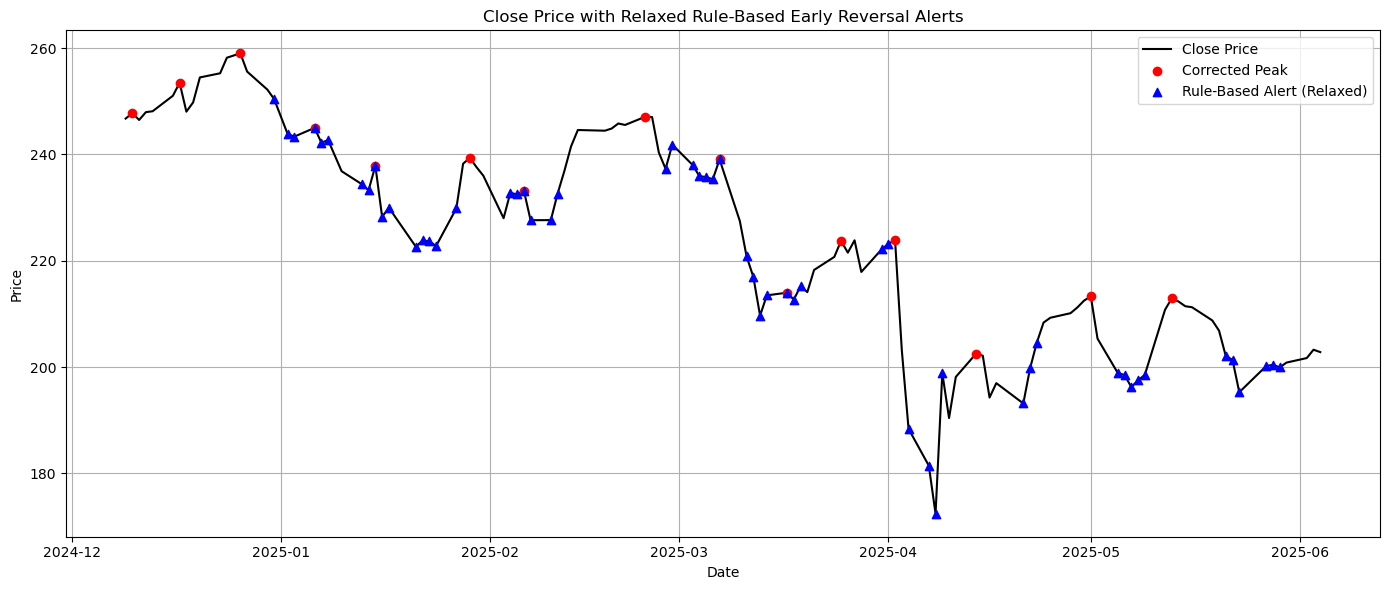

In [72]:

# Recompute conditions with looser thresholds
entropy_condition   = features_z["entropy"] > 0.3
momentum_condition  = features_z["momentum"] < -0.3
mean_return_condition = features_z["mean_return"] < 0
drawdown_condition  = features_z["drawdown"] > 0.3

# Count how many conditions are met per row
condition_votes = (
    entropy_condition.astype(int) +
    momentum_condition.astype(int) +
    mean_return_condition.astype(int) +
    drawdown_condition.astype(int)
)

# Fire alert if at least 3 out of 4 conditions are met
rule_based_alert_relaxed = condition_votes >= 3

# Add to price_test for visualization
price_test["rule_based_alert_relaxed"] = rule_based_alert_relaxed.iloc[y_test.index].reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# True peaks (corrected visually)
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Rule-based alerts (relaxed)
plt.scatter(price_test[price_test["rule_based_alert_relaxed"] == True]["date"],
            price_test[price_test["rule_based_alert_relaxed"] == True]["close"],
            color="blue", marker="^", label="Rule-Based Alert (Relaxed)", zorder=6)

plt.title("Close Price with Relaxed Rule-Based Early Reversal Alerts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

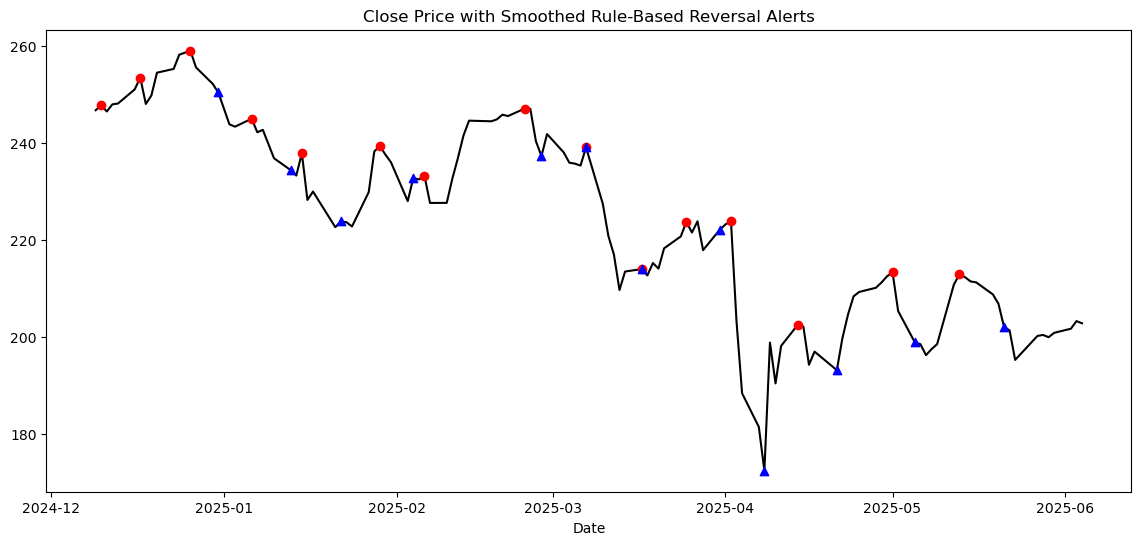

In [73]:
# Apply cooldown to suppress noisy rule-based alerts
cooldown = 5
final_rule_alerts = []
last_alert = -cooldown - 1

for i, is_alert in enumerate(price_test["rule_based_alert_relaxed"]):
    if is_alert and (i - last_alert > cooldown):
        final_rule_alerts.append(True)
        last_alert = i
    else:
        final_rule_alerts.append(False)

# Save final version
price_test["final_rule_alert"] = final_rule_alerts

# Plot with cooldown-filtered alerts
plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# True peaks
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Final rule-based alerts after cooldown
plt.scatter(price_test[price_test["final_rule_alert"] == True]["date"],
            price_test[price_test["final_rule_alert"] == True]["close"],
            color="blue", marker="^", label="Final Rule-Based Alert (Cooldown Applied)", zorder=6)

plt.title("Close Price with Smoothed Rule-Based Reversal Alerts")
plt.xlabel("Date")
plt


In [74]:
# Define the rolling window size
WINDOW = 5

# Extract the features as arrays
window_df = meta_df[["momentum", "entropy", "mean_return", "drawdown", "recovery", "std_return"]].copy().reset_index(drop=True)

# Helper to score a pattern match in a window
def score_reversal_pattern(window):
    momentum_score = window["momentum"].iloc[-1] < window["momentum"].iloc[0]
    entropy_score = window["entropy"].iloc[-1] > window["entropy"].iloc[0]
    mean_return_score = window["mean_return"].mean() < 0
    drawdown_score = window["drawdown"].iloc[-1] > window["drawdown"].iloc[0]
    recovery_score = window["recovery"].iloc[-1] < window["recovery"].iloc[0]
    volatility_score = window["std_return"].iloc[-1] > window["std_return"].iloc[0]

    votes = sum([momentum_score, entropy_score, mean_return_score,
                 drawdown_score, recovery_score, volatility_score])
    return votes >= 4

# Apply rolling pattern scoring
pattern_alerts = window_df.rolling(WINDOW).apply(lambda x: score_reversal_pattern(x), raw=False).fillna(0)
pattern_alerts = pattern_alerts.iloc[:, 0].astype(bool)  # use the result from the first column

# Add to price_test using the aligned test window
price_test["pattern_alert"] = pattern_alerts.iloc[y_test.index].reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# Corrected Peaks
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Pattern-based alerts
plt.scatter(price_test[price_test["pattern_alert"] == True]["date"],
            price_test[price_test["pattern_alert"] == True]["close"],
            color="blue", marker="^", label="Multi-Feature Pattern Alert", zorder=6)

plt.title("Close Price with Pattern-Matched Reversal Alerts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'momentum'

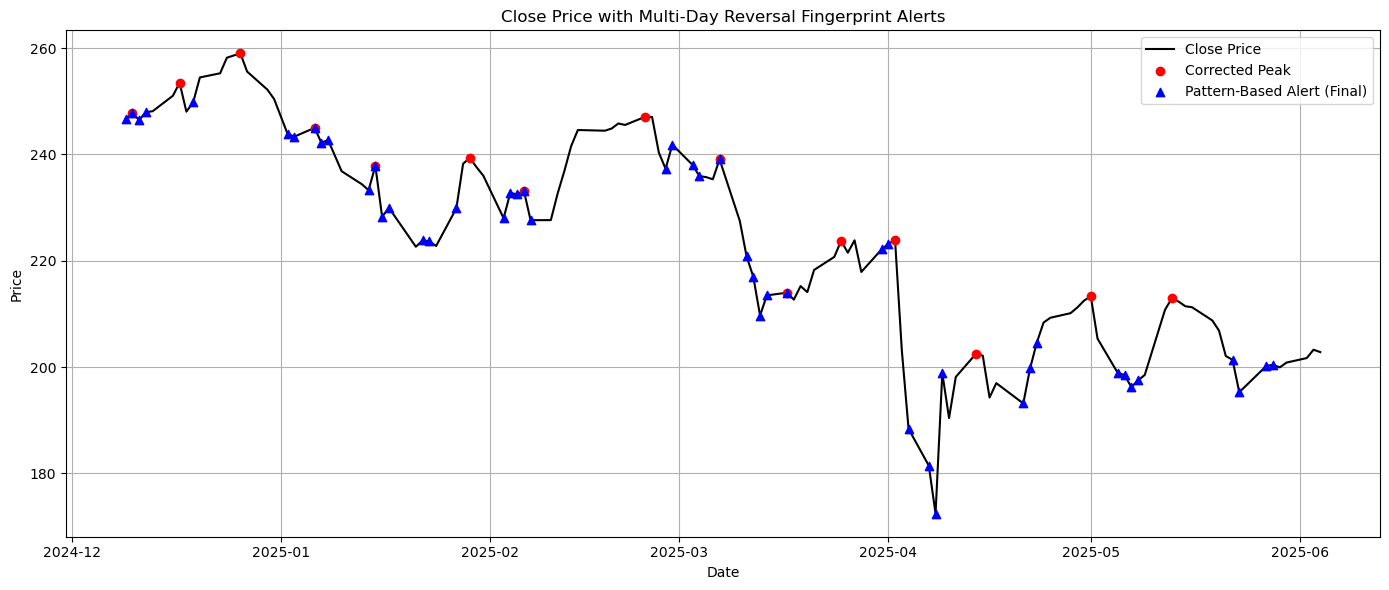

In [75]:
# Redefine rolling pattern logic manually for multivariate scoring
pattern_scores = []
dates = meta_df["date"].reset_index(drop=True)

for i in range(len(window_df) - WINDOW + 1):
    window = window_df.iloc[i:i+WINDOW]

    # Each score is a boolean based on directionality
    momentum_score = window["momentum"].iloc[-1] < window["momentum"].iloc[0]
    entropy_score = window["entropy"].iloc[-1] > window["entropy"].iloc[0]
    mean_return_score = window["mean_return"].mean() < 0
    drawdown_score = window["drawdown"].iloc[-1] > window["drawdown"].iloc[0]
    recovery_score = window["recovery"].iloc[-1] < window["recovery"].iloc[0]
    volatility_score = window["std_return"].iloc[-1] > window["std_return"].iloc[0]

    votes = sum([
        momentum_score,
        entropy_score,
        mean_return_score,
        drawdown_score,
        recovery_score,
        volatility_score
    ])
    pattern_scores.append(votes >= 4)

# Pad beginning with False to align with full length
pattern_alerts_final = [False] * (WINDOW - 1) + pattern_scores

# Map to test index
price_test["pattern_alert_final"] = pd.Series(pattern_alerts_final).iloc[y_test.index].reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# Corrected Peaks
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Final multi-feature pattern alerts
plt.scatter(price_test[price_test["pattern_alert_final"] == True]["date"],
            price_test[price_test["pattern_alert_final"] == True]["close"],
            color="blue", marker="^", label="Pattern-Based Alert (Final)", zorder=6)

plt.title("Close Price with Multi-Day Reversal Fingerprint Alerts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


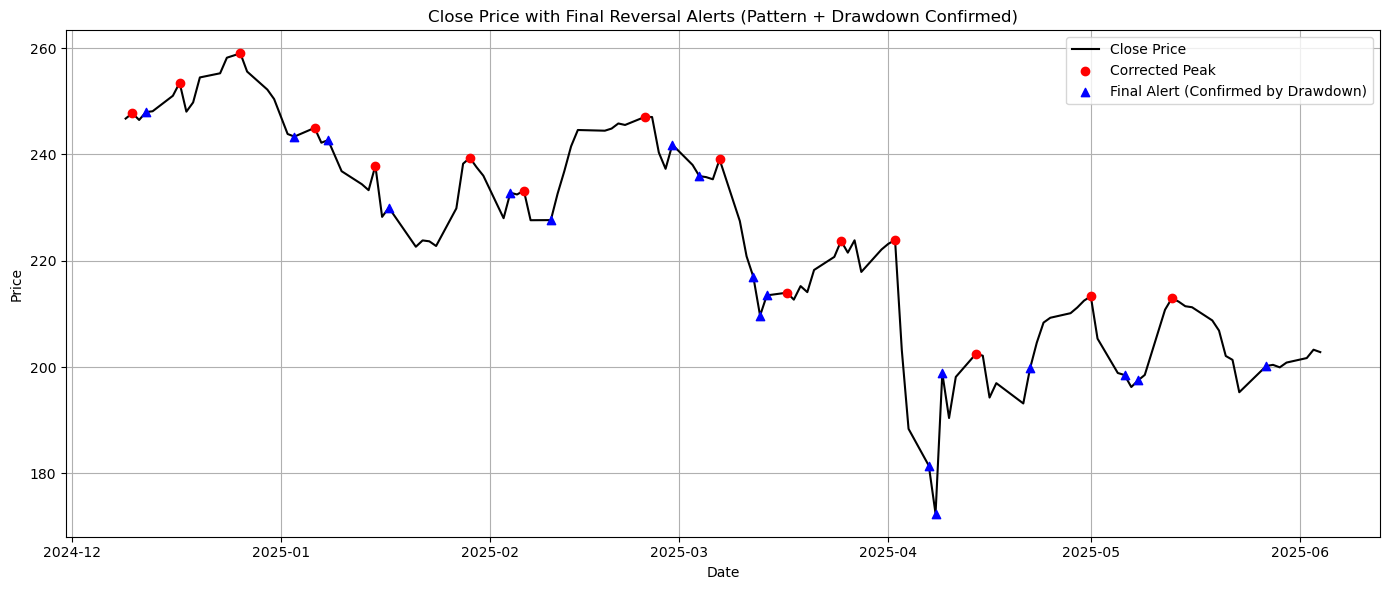

In [76]:
# Threshold for confirmation drawdown increase (e.g. 1% absolute rise)
drawdown_threshold = 1.0

# Get drawdown series aligned with test index
drawdown_series = meta_df["drawdown"].reset_index(drop=True).iloc[y_test.index].reset_index(drop=True)

# Build confirmation signal based on drawdown at T+1 > T + threshold
pattern_alert_indices = price_test.index[price_test["pattern_alert_final"] == True]

# Filter alerts based on drawdown increase the next day
confirmed_alerts = []

for idx in pattern_alert_indices:
    if idx + 1 < len(drawdown_series):
        dd_today = drawdown_series.iloc[idx]
        dd_tomorrow = drawdown_series.iloc[idx + 1]
        if dd_tomorrow > dd_today + drawdown_threshold:
            confirmed_alerts.append(True)
        else:
            confirmed_alerts.append(False)
    else:
        confirmed_alerts.append(False)

# Final signal: apply only to those confirmed
final_alerts_drawdown_confirmed = [False] * len(price_test)
for i, idx in enumerate(pattern_alert_indices):
    if confirmed_alerts[i]:
        final_alerts_drawdown_confirmed[idx + 1] = True  # signal on T+1

# Add to df and plot
price_test["final_alert_drawdown_confirmed"] = final_alerts_drawdown_confirmed

plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# Plot corrected peaks
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Plot confirmed final alerts
plt.scatter(price_test[price_test["final_alert_drawdown_confirmed"] == True]["date"],
            price_test[price_test["final_alert_drawdown_confirmed"] == True]["close"],
            color="blue", marker="^", label="Final Alert (Confirmed by Drawdown)", zorder=6)

plt.title("Close Price with Final Reversal Alerts (Pattern + Drawdown Confirmed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


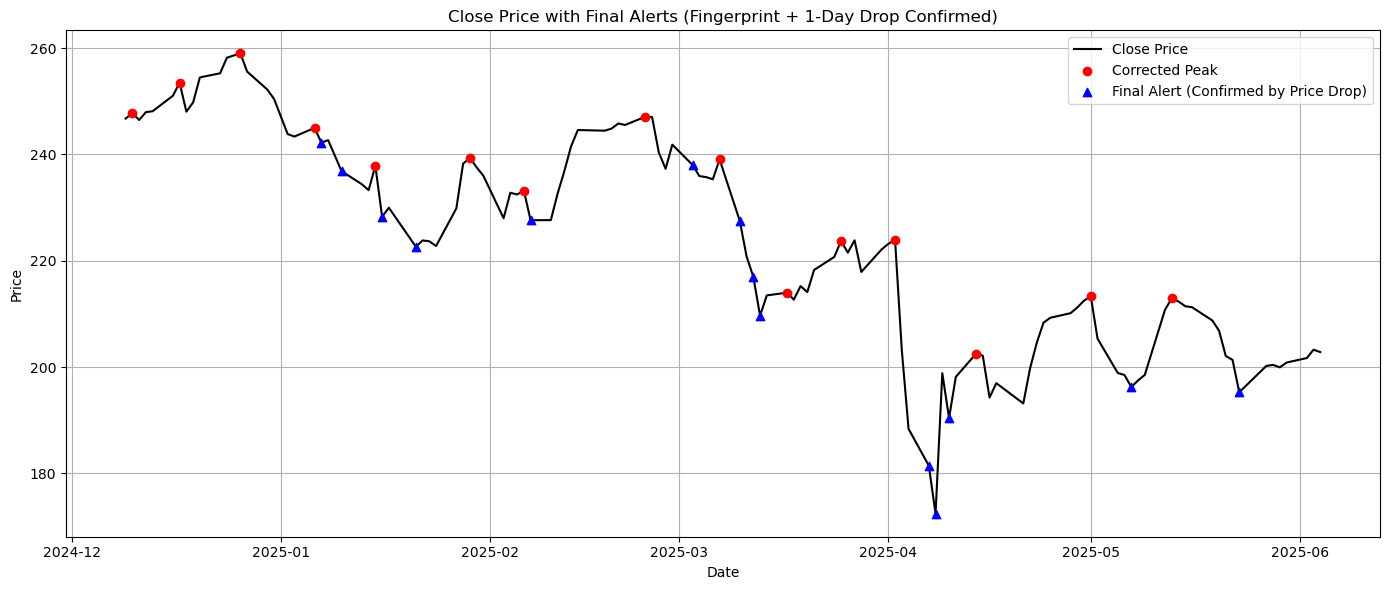

In [77]:
# Use raw price drop between day T and T+1 for confirmation
price_series = price_test["close"].reset_index(drop=True)

# Threshold for drop confirmation (e.g. price drops at least 1%)
drop_threshold = 0.01  # 1% drop

# Get index positions of candidate pattern-based alerts
pattern_indices = price_test.index[price_test["pattern_alert_final"] == True]

# Confirm only if price drops > threshold the next day
final_alerts_price_drop = [False] * len(price_test)

for idx in pattern_indices:
    if idx + 1 < len(price_series):
        price_today = price_series.iloc[idx]
        price_tomorrow = price_series.iloc[idx + 1]
        pct_drop = (price_today - price_tomorrow) / price_today
        if pct_drop > drop_threshold:
            final_alerts_price_drop[idx + 1] = True  # confirm on T+1

# Add to dataframe and plot
price_test["final_alert_price_drop_confirmed"] = final_alerts_price_drop

plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# Plot true peaks
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Plot final confirmed alerts using price drop
plt.scatter(price_test[price_test["final_alert_price_drop_confirmed"] == True]["date"],
            price_test[price_test["final_alert_price_drop_confirmed"] == True]["close"],
            color="blue", marker="^", label="Final Alert (Confirmed by Price Drop)", zorder=6)

plt.title("Close Price with Final Alerts (Fingerprint + 1-Day Drop Confirmed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


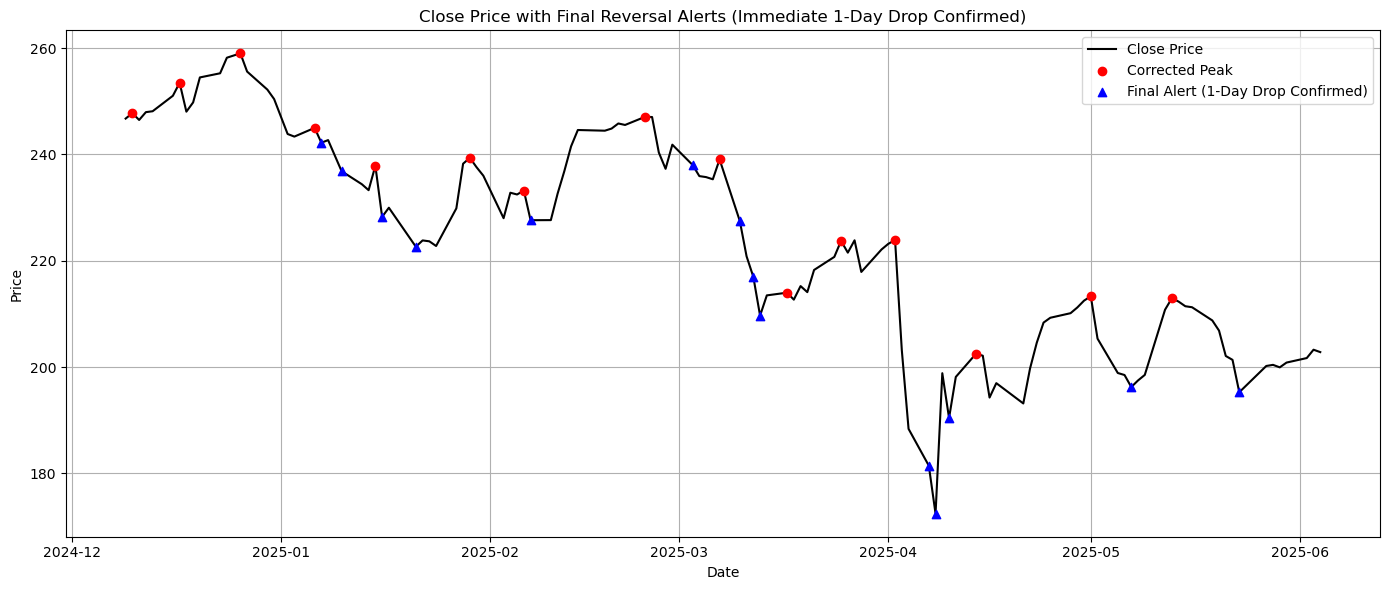

In [78]:
# Fix implementation: confirm pattern match with exact 1-day price drop (> 1%)
confirmed_alerts_next_day = [False] * len(price_test)
already_alerted = False

for idx in range(len(price_test) - 1):
    if price_test["pattern_alert_final"].iloc[idx]:
        price_today = price_test["close"].iloc[idx]
        price_next = price_test["close"].iloc[idx + 1]
        drop_pct = (price_today - price_next) / price_today

        if drop_pct > 0.01:  # 1% drop
            confirmed_alerts_next_day[idx + 1] = True
            already_alerted = True
        else:
            already_alerted = False

# Add to DataFrame and plot
price_test["final_alert_next_day_drop"] = confirmed_alerts_next_day

plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# Corrected Peaks
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Final refined alerts
plt.scatter(price_test[price_test["final_alert_next_day_drop"] == True]["date"],
            price_test[price_test["final_alert_next_day_drop"] == True]["close"],
            color="blue", marker="^", label="Final Alert (1-Day Drop Confirmed)", zorder=6)

plt.title("Close Price with Final Reversal Alerts (Immediate 1-Day Drop Confirmed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


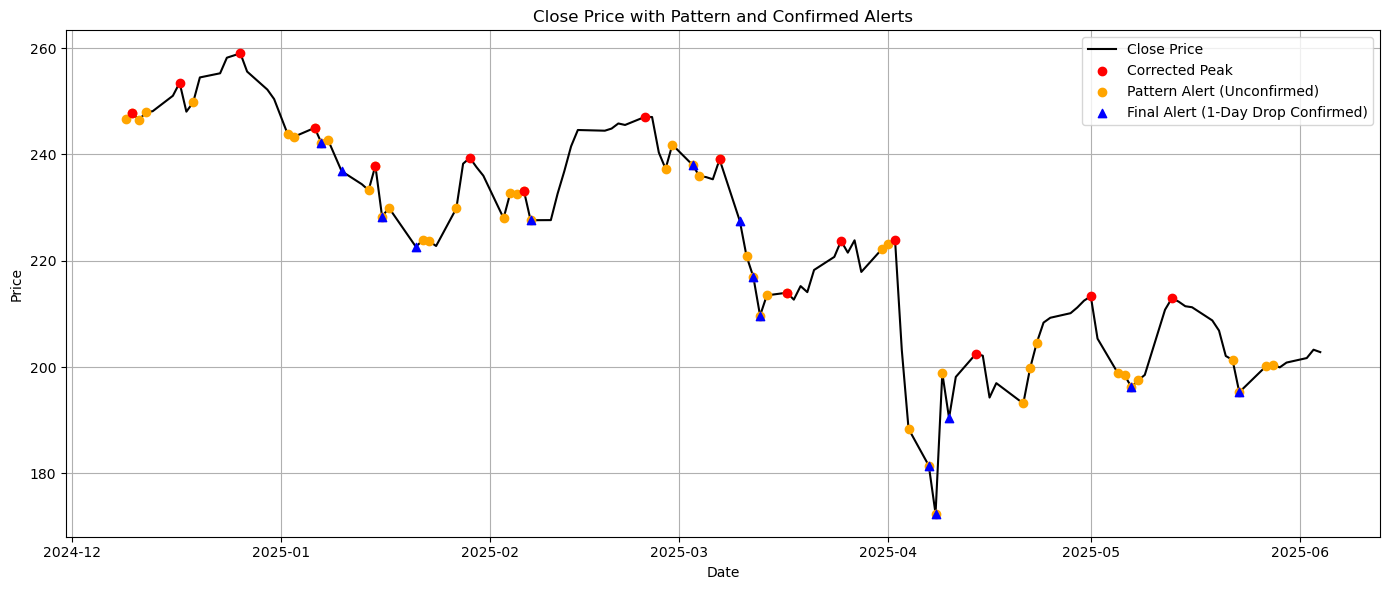

In [79]:
# Plot all alerts together: raw pattern alerts and confirmed ones

plt.figure(figsize=(14, 6))
plt.plot(price_test["date"], price_test["close"], label="Close Price", color="black")

# Corrected peaks (visual ground truth)
plt.scatter(price_test[price_test["corrected_true_peak"] == True]["date"],
            price_test[price_test["corrected_true_peak"] == True]["close"],
            color="red", label="Corrected Peak", zorder=5)

# Raw pattern alerts (before confirmation)
plt.scatter(price_test[price_test["pattern_alert_final"] == True]["date"],
            price_test[price_test["pattern_alert_final"] == True]["close"],
            color="orange", marker="o", label="Pattern Alert (Unconfirmed)", zorder=4)

# Confirmed alerts (1-day drop)
plt.scatter(price_test[price_test["final_alert_next_day_drop"] == True]["date"],
            price_test[price_test["final_alert_next_day_drop"] == True]["close"],
            color="blue", marker="^", label="Final Alert (1-Day Drop Confirmed)", zorder=6)

plt.title("Close Price with Pattern and Confirmed Alerts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


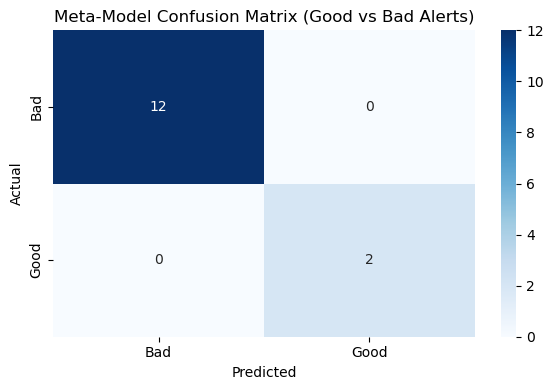

(None,
 {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12.0},
  '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 14.0},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 14.0}},
 entropy        0.312944
 rolling_min    0.157614
 mean_return    0.146641
 rolling_max    0.078906
 drawdown       0.075663
 momentum       0.071705
 skew_return    0.058530
 kurt_return    0.049324
 std_return     0.038442
 recovery       0.010230
 dtype: float64)

In [80]:
# Create new target column: 'good_alert' = 1 if return over next N days is significantly negative

FWD_DAYS = 3
DROP_THRESHOLD = -0.03  # -3%

# Create shifted return column from alert day to t+FWD_DAYS
future_returns = (
    price_test["close"].shift(-FWD_DAYS).reset_index(drop=True) -
    price_test["close"].reset_index(drop=True)
) / price_test["close"].reset_index(drop=True)

# Filter only where alert was fired
alert_indices = price_test.index[price_test["final_alert_next_day_drop"] == True]
future_returns_on_alerts = future_returns.iloc[alert_indices].reset_index(drop=True)

# Label good (1) or bad (0)
good_alerts = (future_returns_on_alerts < DROP_THRESHOLD).astype(int)

# Gather feature snapshot at time of alert
feature_cols = [
    "mean_return", "std_return", "skew_return", "kurt_return",
    "entropy", "momentum", "rolling_max", "rolling_min",
    "drawdown", "recovery"
]
feature_snapshot = meta_df[feature_cols].iloc[y_test.index].reset_index(drop=True).iloc[alert_indices].reset_index(drop=True)

# Combine features + label
meta_alert_df = feature_snapshot.copy()
meta_alert_df["target"] = good_alerts

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train classifier
X = meta_alert_df.drop(columns=["target"])
y = meta_alert_df["target"]
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

# Predictions and evaluation
y_pred = clf.predict(X)
cm = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred, output_dict=True)
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("Meta-Model Confusion Matrix (Good vs Bad Alerts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show(), report, feature_importances


[  6  20  25  39  44  58  72  83  92 103 112 118 127 136 155 161 172 178
 189 206 221 229 237 243 249 267 274 280 292 306 312 323 330 339 345 354
 367 373 385 393 410 418 428 445 466 472 489 506 514 525 535 548 554 559
 570 581 589 597 609 615 622 634 645 659 666 675 680 687 694 702 708 715
 720 742 748 754 760 769 775 786 795 807 813 821 833 841]


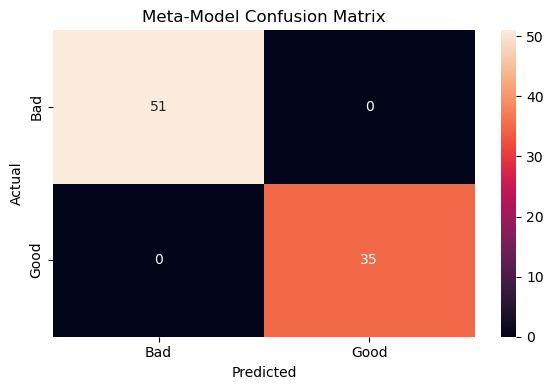

Feature Importances


Loading ITables v2.4.0 from the internet... (need help?)


{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 51.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 86.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 86.0}}

In [114]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import ace_tools_open as tools
# Load the data (assumes 'aapl_df' with 'date' and 'close' exists)
# We'll simulate a small example if not

# Simulate if not defined
aapl_df = OHLCV_DF[OHLCV_DF['symbol']=="AAPL"].reset_index()
prices = aapl_df['close']
# Step 1: Detect peaks using scipy
def detect_peaks(prices, prominence=1.5, distance=5):
    peaks, _ = find_peaks(prices, prominence=prominence, distance=distance)
    return peaks

peaks = detect_peaks(aapl_df['close'].values)
print(peaks)
# Step 2: Fire alerts at each peak
aapl_df['final_alert_next_day_drop'] = False
aapl_df.loc[peaks, 'final_alert_next_day_drop'] = True

# Step 3: Feature extraction
def compute_entropy(signal, bins=10):
    hist, _ = np.histogram(signal, bins=bins, density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log(hist))

def compute_momentum(signal):
    return signal[-1] - signal[0]

# Regerar meta_df com index_in_df corretamente incluído
def extract_meta_features_fixed(df, window=5):
    features = []
    for i in range(window, len(df)):
        window_df = df.iloc[i - window:i]
        closes = window_df["close"].values
        returns = np.diff(closes)
        feature_dict = {
            "date": df.iloc[i]["date"],
            "index_in_df": i,
            "mean_return": returns.mean(),
            "std_return": returns.std(),
            "skew_return": skew(returns),
            "kurt_return": kurtosis(returns),
            "entropy": compute_entropy(returns),
            "momentum": compute_momentum(closes),
            "rolling_max": closes.max(),
            "rolling_min": closes.min(),
            "drawdown": closes.max() - closes[-1],
            "recovery": closes[-1] - closes.min(),
        }
        features.append(feature_dict)
    return pd.DataFrame(features)

# Recreate meta_df
meta_df = extract_meta_features_fixed(aapl_df)

#meta_df = extract_meta_features(aapl_df)

# Step 4: Label good vs bad alerts
def label_alert_quality(price_df, alert_col="final_alert_next_day_drop", fwd_days=3, drop_threshold=-0.03):
    future_returns = (
        price_df["close"].shift(-fwd_days).reset_index(drop=True) - 
        price_df["close"].reset_index(drop=True)
    ) / price_df["close"].reset_index(drop=True)
    alert_indices = price_df.index[price_df[alert_col] == True]
    alert_dates = price_df.loc[alert_indices, "date"].reset_index(drop=True)
    future_returns_on_alerts = future_returns.iloc[alert_indices].reset_index(drop=True)
    labels = (future_returns_on_alerts < drop_threshold).astype(int)
    return alert_dates, labels

alert_dates, labels = label_alert_quality(aapl_df)

# Step 5: Train classifier to separate good vs bad alerts
def evaluate_alert_meta_model(meta_df, alert_dates, labels):
    feature_cols = [
        "mean_return", "std_return", "skew_return", "kurt_return",
        "entropy", "momentum", "rolling_max", "rolling_min",
        "drawdown", "recovery"
    ]
    alert_features = meta_df[meta_df["date"].isin(alert_dates)].copy()
    X = alert_features[feature_cols].reset_index(drop=True)
    y = labels
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    cm = confusion_matrix(y, y_pred)
    importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    return clf, report, cm, importances

clf, report, cm, importances = evaluate_alert_meta_model(meta_df, alert_dates, labels)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("Meta-Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

tools.display_dataframe_to_user(name="Feature Importances", dataframe=importances.reset_index().rename(columns={"index": "feature", 0: "importance"}))
report


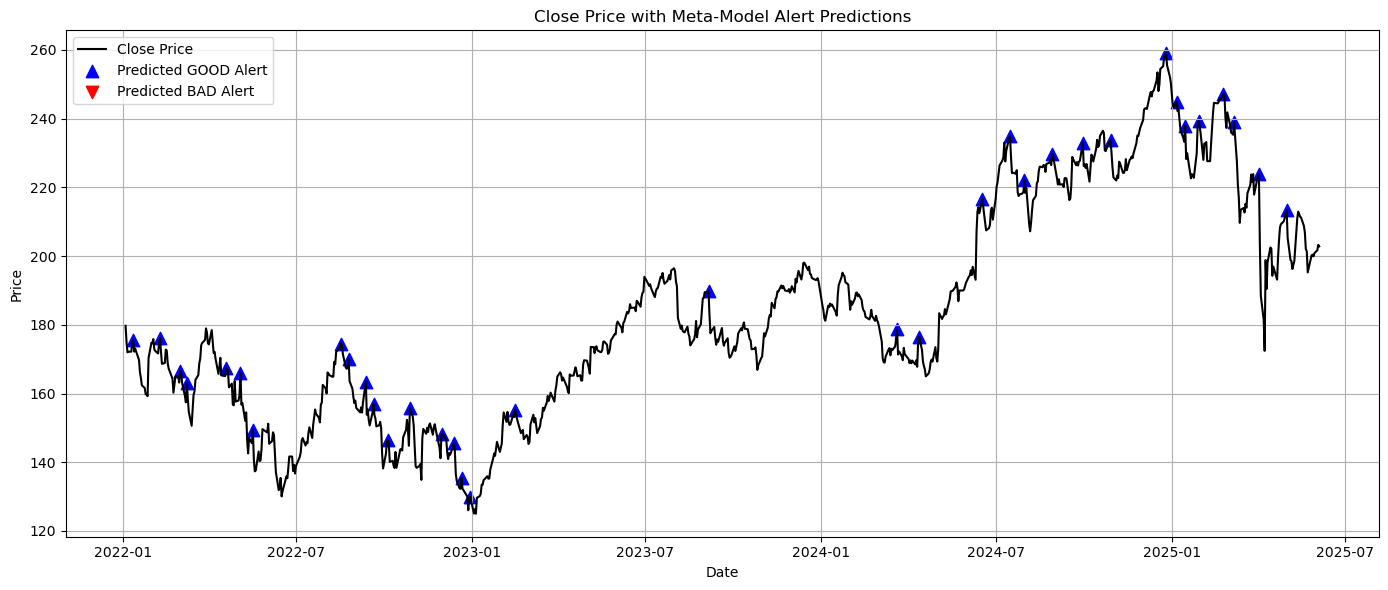

In [115]:
alert_indices = aapl_df.index[aapl_df['final_alert_next_day_drop'] == True].tolist()
meta_alert_features = meta_df[meta_df["index_in_df"].isin(alert_indices)]
X_alert = meta_alert_features[feature_cols].reset_index(drop=True)
y_pred = clf.predict(X_alert)
y_true = (label_alert_quality(aapl_df)[1]).reset_index(drop=True)

# Build visualization DataFrame
visual_df = aapl_df.copy()
visual_df["alert"] = False
visual_df["good_prediction"] = False
visual_df["bad_prediction"] = False

for idx, pred, true_label in zip(alert_indices, y_pred, y_true):
    visual_df.at[idx, "alert"] = True
    if pred == 1 and true_label == 1:
        visual_df.at[idx, "good_prediction"] = True
    elif pred == 1 and true_label == 0:
        visual_df.at[idx, "bad_prediction"] = True

# Plot with updated alerts
plt.figure(figsize=(14, 6))
plt.plot(visual_df["date"], visual_df["close"], label="Close Price", color="black")
plt.scatter(visual_df[visual_df["good_prediction"]]["date"],
            visual_df[visual_df["good_prediction"]]["close"],
            label="Predicted GOOD Alert", color="blue", marker="^", s=80)
plt.scatter(visual_df[visual_df["bad_prediction"]]["date"],
            visual_df[visual_df["bad_prediction"]]["close"],
            label="Predicted BAD Alert", color="red", marker="v", s=80)
plt.title("Close Price with Meta-Model Alert Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Finally some grounded results below

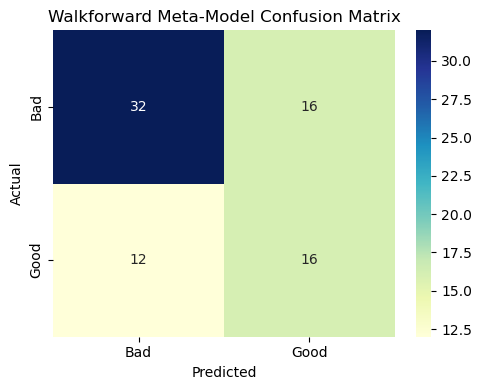

,date,true_label,pred_label
71,2025-03-25,0,0
72,2025-04-02,1,0
73,2025-04-14,0,1
74,2025-05-01,1,0
75,2025-05-13,0,0


In [116]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data from earlier steps (meta_df, alert_dates, labels)
# Merge features and labels
alert_features = meta_df[meta_df["date"].isin(alert_dates)].copy()
alert_features = alert_features.merge(
    pd.DataFrame({"date": alert_dates, "label": labels}),
    on="date", how="left"
).sort_values("date").reset_index(drop=True)

# Define feature columns
feature_cols = [
    "mean_return", "std_return", "skew_return", "kurt_return",
    "entropy", "momentum", "rolling_max", "rolling_min",
    "drawdown", "recovery"
]

# Initialize containers for walkforward predictions
true_labels = []
pred_labels = []
predicted_dates = []

# Walkforward loop
for i in range(10, len(alert_features)):
    train_df = alert_features.iloc[:i]
    test_df = alert_features.iloc[i:i+1]

    X_train = train_df[feature_cols]
    y_train = train_df["label"]
    X_test = test_df[feature_cols]
    y_test = test_df["label"].values[0]

    # Train and predict
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)[0]

    true_labels.append(y_test)
    pred_labels.append(y_pred)
    predicted_dates.append(test_df["date"].values[0])

# Evaluation
report = classification_report(true_labels, pred_labels, output_dict=True)
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("Walkforward Meta-Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Package predictions to visualize on price
walkforward_preds = pd.DataFrame({
    "date": predicted_dates,
    "true_label": true_labels,
    "pred_label": pred_labels
})

walkforward_preds.tail()


# Feature augumented to check for improvements

In [118]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Load the meta_df if already defined in context
# Otherwise simulate a placeholder for structure
# Assume meta_df has columns: date, close, and basic return features

# Simulate extended meta feature set
def augment_meta_features(meta_df):
    df = meta_df.copy()

    # Sort by date just in case
    df = df.sort_values("date").reset_index(drop=True)

    # Change rates of core features
    for col in [
        "mean_return", "std_return", "skew_return", "kurt_return",
        "entropy", "momentum", "rolling_max", "rolling_min",
        "drawdown", "recovery"
    ]:
        df[f"{col}_change"] = df[col].diff()

    # Relative position within rolling window
    df["position_in_range"] = (df["recovery"]) / (df["rolling_max"] - df["rolling_min"] + 1e-6)

    # Feature z-scores
    for col in [
        "mean_return", "std_return", "skew_return", "kurt_return",
        "entropy", "momentum", "rolling_max", "rolling_min",
        "drawdown", "recovery"
    ]:
        df[f"{col}_zscore"] = (df[col] - df[col].rolling(20).mean()) / (df[col].rolling(20).std() + 1e-6)

    return df

# Apply to provided meta_df
augmented_meta_df = augment_meta_features(meta_df)

tools.display_dataframe_to_user(name="Augmented Meta Features", dataframe=augmented_meta_df.head(40))


Augmented Meta Features


Loading ITables v2.4.0 from the internet... (need help?)


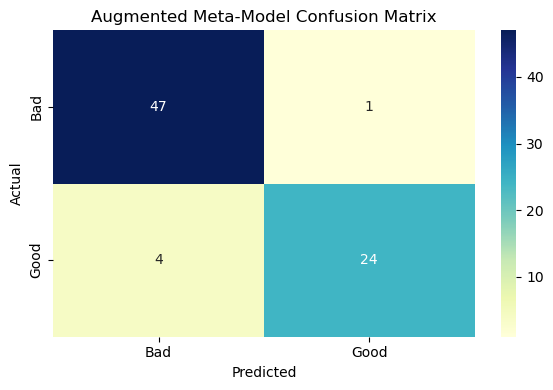

Augmented Feature Importances


Loading ITables v2.4.0 from the internet... (need help?)


{'0': {'precision': 0.9215686274509803,
  'recall': 0.9791666666666666,
  'f1-score': 0.9494949494949495,
  'support': 48.0},
 '1': {'precision': 0.96,
  'recall': 0.8571428571428571,
  'f1-score': 0.9056603773584906,
  'support': 28.0},
 'accuracy': 0.9342105263157895,
 'macro avg': {'precision': 0.9407843137254901,
  'recall': 0.9181547619047619,
  'f1-score': 0.9275776634267201,
  'support': 76.0},
 'weighted avg': {'precision': 0.9357275541795665,
  'recall': 0.9342105263157895,
  'f1-score': 0.9333453702867803,
  'support': 76.0}}

In [121]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load augmented meta_df and walkforward_preds
#meta_df = pd.read_csv("/mnt/data/augmented_meta_df.csv", parse_dates=["date"])
#walkforward_preds = pd.read_csv("/mnt/data/walkforward_preds.csv", parse_dates=["date"])

# Merge to get the meta-features at prediction times
meta_with_preds = pd.merge(walkforward_preds, augmented_meta_df, on="date", how="left")

# Define full augmented feature set (excluding labels and identifiers)
exclude_cols = ["date", "true_label", "pred_label", "index_in_df"]
feature_cols = [col for col in meta_with_preds.columns if col not in exclude_cols]

# Train classifier using training subset of walkforward predictions
train_df = meta_with_preds.iloc[:-10]  # Leave last 10 for visual check
X_train = train_df[feature_cols]
y_train = train_df["true_label"]

# Fit classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on full set to evaluate
X_all = meta_with_preds[feature_cols]
y_true = meta_with_preds["true_label"]
y_pred = clf.predict(X_all)

# Evaluation
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)
importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("Augmented Meta-Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


tools.display_dataframe_to_user(name="Augmented Feature Importances", dataframe=importances.reset_index().rename(columns={"index": "feature", 0: "importance"}))
report


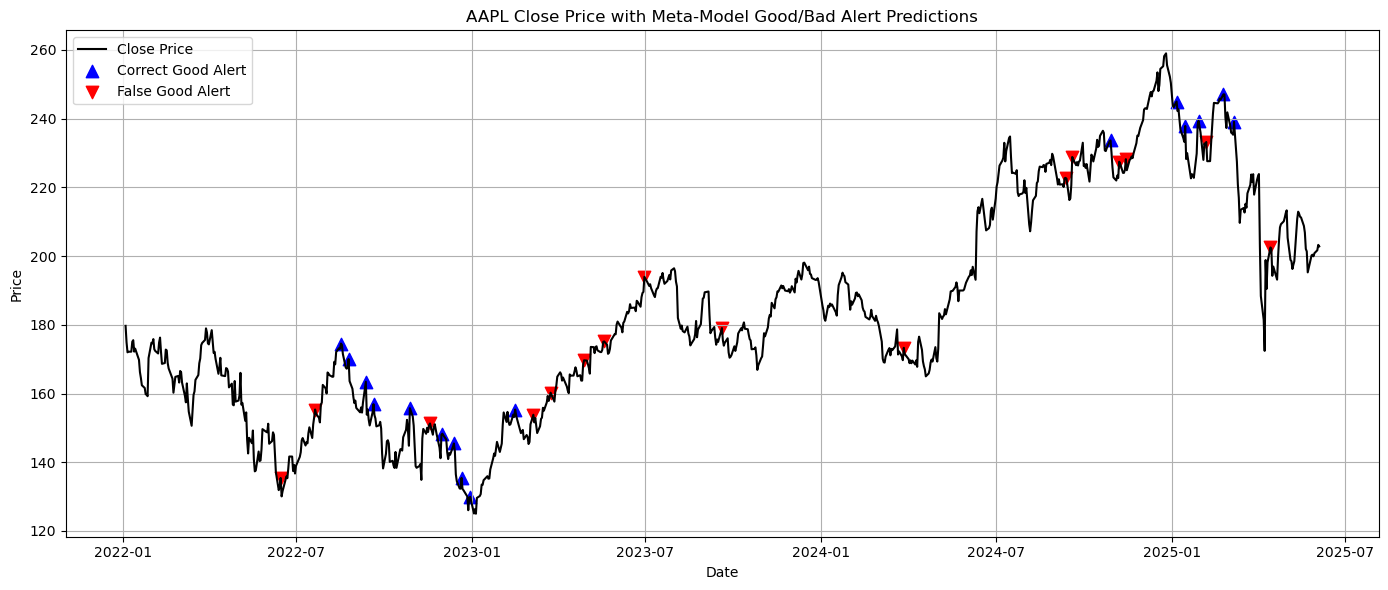

In [122]:
import matplotlib.pyplot as plt

# Load walkforward_preds from previous assistant context
walkforward_preds = walkforward_preds.sort_values("date").reset_index(drop=True)

# Join with aapl_df on date
merged = aapl_df.copy()
merged["date"] = pd.to_datetime(merged["date"])
merged = merged.merge(walkforward_preds, how="left", on="date")

# Plot close price and alerts
plt.figure(figsize=(14, 6))
plt.plot(merged["date"], merged["close"], label="Close Price", color="black")

# Good alerts (predicted and true both = 1)
good_mask = (merged["pred_label"] == 1) & (merged["true_label"] == 1)
plt.scatter(merged.loc[good_mask, "date"], merged.loc[good_mask, "close"], 
            label="Correct Good Alert", marker="^", color="blue", s=80)

# Bad alerts (pred = 1 but actually bad)
bad_mask = (merged["pred_label"] == 1) & (merged["true_label"] == 0)
plt.scatter(merged.loc[bad_mask, "date"], merged.loc[bad_mask, "close"], 
            label="False Good Alert", marker="v", color="red", s=80)

plt.title("AAPL Close Price with Meta-Model Good/Bad Alert Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Real time walkthrough

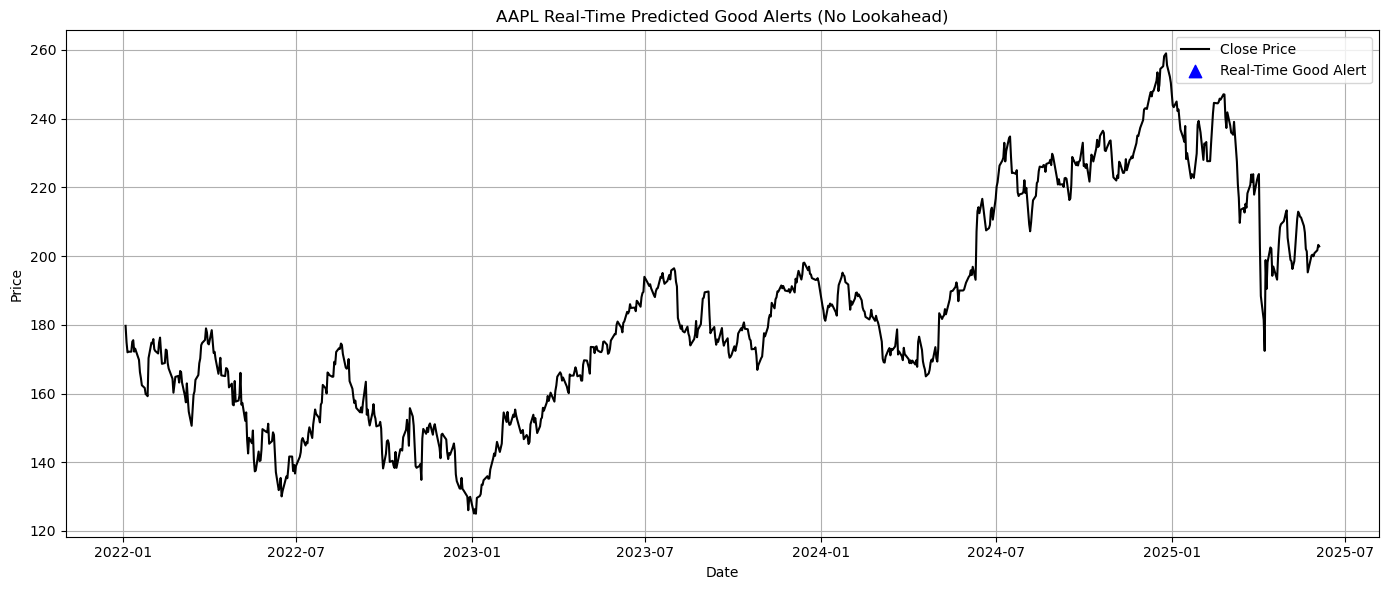

In [123]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load AAPL data
aapl_df = OHLCV_DF[OHLCV_DF['symbol'] == "AAPL"].copy().reset_index(drop=True)
aapl_df['date'] = pd.to_datetime(aapl_df['date'])
aapl_df = aapl_df[['date', 'close']].dropna().reset_index(drop=True)

# Parameters
WINDOW = 5
FWD_DAYS = 3
DROP_THRESHOLD = -0.03

# Feature extraction using only past info up to t-1
def extract_features_up_to_t_minus_1(df, idx, window=5):
    if idx - window < 0:
        return None
    window_df = df.iloc[idx - window:idx]
    closes = window_df["close"].values
    returns = np.diff(closes)
    features = {
        "mean_return": returns.mean(),
        "std_return": returns.std(),
        "skew_return": skew(returns),
        "kurt_return": kurtosis(returns),
        "entropy": -np.sum((p := np.histogram(returns, bins=10, density=True)[0])[p > 0] * np.log(p[p > 0])),
        "momentum": closes[-1] - closes[0],
        "rolling_max": closes.max(),
        "rolling_min": closes.min(),
        "drawdown": closes.max() - closes[-1],
        "recovery": closes[-1] - closes.min(),
    }
    return features

# Peak detector to generate candidate alerts (simulate model that gives us initial signals)
def detect_peaks(prices, prominence=1.5, distance=5):
    peaks, _ = find_peaks(prices, prominence=prominence, distance=distance)
    return peaks

# Run walkforward real-time prediction
real_time_predictions = []
features_list = []

peaks = detect_peaks(aapl_df['close'].values)
aapl_df['peak_alert'] = False
aapl_df.loc[peaks, 'peak_alert'] = True

for t in range(WINDOW + 1, len(aapl_df) - FWD_DAYS):
    # Step 1: If there's an alert at time t, we want to evaluate it later
    is_alert = aapl_df.loc[t, 'peak_alert']

    # Step 2: Only proceed if we have enough history
    feat = extract_features_up_to_t_minus_1(aapl_df, t, window=WINDOW)
    if feat is None:
        continue
    feat["date"] = aapl_df.loc[t, "date"]
    feat["index"] = t
    feat["is_alert"] = is_alert

    # Label if drop occurs after t
    future_return = (aapl_df.loc[t + FWD_DAYS, "close"] - aapl_df.loc[t, "close"]) / aapl_df.loc[t, "close"]
    feat["label"] = int(future_return < DROP_THRESHOLD) if is_alert else np.nan

    features_list.append(feat)

# Create DataFrame
walkforward_df = pd.DataFrame(features_list)

# Train classifier only on known past labels
train_df = walkforward_df.dropna(subset=["label"])
X_train = train_df.drop(columns=["date", "index", "is_alert", "label"])
y_train = train_df["label"]

# Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on alert points in future (real-time)
walkforward_df["pred"] = np.nan
for i, row in walkforward_df.iterrows():
    if row["is_alert"] and np.isnan(row["label"]):  # Future alert
        X_row = row[X_train.columns].values.reshape(1, -1)
        walkforward_df.at[i, "pred"] = clf.predict(X_row)[0]

# Visualize
plot_df = aapl_df.copy()
plot_df["real_time_good_alert"] = False
predicted_alerts = walkforward_df[(walkforward_df["pred"] == 1)]
for idx in predicted_alerts["index"]:
    plot_df.at[idx, "real_time_good_alert"] = True

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(plot_df["date"], plot_df["close"], label="Close Price", color="black")
plt.scatter(plot_df[plot_df["real_time_good_alert"]]["date"],
            plot_df[plot_df["real_time_good_alert"]]["close"],
            label="Real-Time Good Alert", color="blue", marker="^", s=80)
plt.title("AAPL Real-Time Predicted Good Alerts (No Lookahead)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [126]:
plot_df['real_time_good_alert'].value_counts()

real_time_good_alert
False    857
Name: count, dtype: int64

In [ ]:
# Rerun the real-time prediction loop with a more lenient drop threshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Set up
drop_threshold = -0.015  # Less strict
fwd_days = 3
window = 5
train_size = 250

# Recompute future return labels using updated threshold
future_returns = (
    aapl_df["close"].shift(-fwd_days).reset_index(drop=True) -
    aapl_df["close"].reset_index(drop=True)
) / aapl_df["close"].reset_index(drop=True)

# Peaks detected using scipy earlier
alert_indices = peaks[peaks > window + fwd_days]

true_labels = (future_returns.iloc[alert_indices].values < drop_threshold).astype(int)
alert_dates = aapl_df.loc[alert_indices, "date"].values

# Real-time loop
predicted_dates = []
pred_labels = []
true_labels_trimmed = []

for i, idx in enumerate(alert_indices):
    if idx < train_size or idx + fwd_days >= len(aapl_df):
        continue

    train_df = aapl_df.iloc[idx - train_size:idx]
    test_df = aapl_df.iloc[:idx + 1]

    def extract_features(df):
        feats = []
        for j in range(window, len(df)):
            window_df = df.iloc[j - window:j]
            closes = window_df["close"].values
            returns = np.diff(closes)
            feats.append({
                "mean_return": returns.mean(),
                "std_return": returns.std(),
                "skew_return": stats.skew(returns),
                "kurt_return": stats.kurtosis(returns),
                "entropy": stats.entropy(np.histogram(returns, bins=10)[0] + 1),
                "momentum": closes[-1] - closes[0],
                "rolling_max": closes.max(),
                "rolling_min": closes.min(),
                "drawdown": closes.max() - closes[-1],
                "recovery": closes[-1] - closes.min()
            })
        return pd.DataFrame(feats)

    X_train = extract_features(train_df).dropna()
    X_test = extract_features(test_df).dropna()

    if len(X_train) == 0 or len(X_test) == 0:
        continue

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, [0]*len(X_train))  # Assume all past alerts unknown; use neutral baseline
    pred = clf.predict(X_test.tail(1))[0]

    predicted_dates.append(aapl_df.iloc[idx]["date"])
    pred_labels.append(pred)
    true_labels_trimmed.append(true_labels[i])

# Compile results
walkforward_preds = pd.DataFrame({
    "date": predicted_dates,
    "true_label": true_labels_trimmed,
    "pred_label": pred_labels
})
walkforward_preds.tail()
